In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
import time
from Doublet_Functions import calcDoubletFraction, getInstrinsicViscosity, getStress
import datetime
from sklearn.metrics import r2_score

In [2]:
def slope():
    result = calcDoubletFraction(phi, Ca, 1.0, r, 0, angle)
    dfg = result[1][0]
    diffpos = result[4][0,0:len(dfg)]
    stress = getStress(phi, Ca, 0, 0, ncycle, angle)[:,8][0:len(dfg)]
    time = np.array(list(range(len(dfg))))

    w = 2
    st, et = 0, 1900
    local_min_time = []

    avg_distance = []
    max_distance = []
    avg_stress = []
    max_stress = []

    first_min = 1
    threshold_distance = 0.5
    threshold_stress = 0.0002
    distance_sum, distance_period, distance_max = 0, 0, -1
    stress_sum, stress_max = 0, -1

    for t in time[st+w:et-w]:
        if dfg[t] == 1:
            # interval
            if first_min == 0:
                distance_sum += diffpos[t]
                stress_sum += stress[t]
                distance_period += 1
                if diffpos[t] > distance_max:
                    distance_max = diffpos[t]
                if stress[t] > stress_max:
                    stress_max = stress[t]
                '''
                if distance_period <= w:
                    stress_head += stress[t]
                    stress_tail += stress[t]
                else:
                    stress_tail += (stress[t] - stress[t-w])
                '''


            # local min
            if (((diffpos[t-1]-diffpos[t]) > 0) and ((diffpos[t+1]-diffpos[t]) > 0)):
                if (((diffpos[t-w]-diffpos[t]) > threshold_distance) and ((diffpos[t+w]-diffpos[t]) > threshold_distance)):
                    #local_min_time.append(t)
                    if first_min == 1:
                        #print(t)
                        first_min = 0
                    else:
                        avg_distance.append(distance_sum/distance_period)
                        max_distance.append(distance_max)
                        avg_stress.append(stress_sum/distance_period)
                        max_stress.append(stress_max)
                        #middle_avg_stress.append((stress_sum-stress_head-stress_tail)/(distance_period-2*w))
                        distance_sum, distance_period, distance_max = 0, 0, -1
                        stress_sum, stress_max = 0, -1
                        #stress_head, stress_tail = 0, 0
        else:
            first_min = 1

    output = []
    if len(avg_distance) <= 20:
        output.append(0)
    else:
        output.append(1)
    
        m, b = np.polyfit(avg_distance, avg_stress, 1)
        fit_distance = np.array(avg_distance)
        fit_stress = m*fit_distance + b
        r2 = r2_score(avg_stress, fit_stress)
        output.append(m)

        m, b = np.polyfit(max_distance, max_stress, 1)
        fit_distance = np.array(max_distance)
        fit_stress = m*fit_distance + b
        r2 = r2_score(max_stress, fit_stress)
        output.append(m)
    
    return output

    '''
    m, b = np.polyfit(avg_distance, avg_stress, 1)
    fit_distance = np.array(avg_distance)
    fit_stress = m*fit_distance + b
    r2 = r2_score(avg_stress, fit_stress)
    print(r2, m, b)

    plt.figure(figsize=(8,6))
    plt.plot(avg_distance, avg_stress, "o")
    plt.plot(fit_distance, fit_stress)
    plt.xlabel("interparticle distance")
    plt.ylabel("stress")
    plt.ylim(bottom=0.)
    plt.title("Avg-Avg")


    m, b = np.polyfit(max_distance, max_stress, 1)
    fit_distance = np.array(max_distance)
    fit_stress = m*fit_distance + b
    r2 = r2_score(max_stress, fit_stress)
    print(r2, m, b)

    plt.figure(figsize=(8,6))
    plt.plot(max_distance, max_stress, "o")
    plt.plot(fit_distance, fit_stress)
    plt.xlabel("interparticle distance")
    plt.ylabel("stress")
    plt.ylim(bottom=0.)
    plt.title("Max-Max")


    m, b = np.polyfit(max_distance, middle_avg_stress, 1)
    fit_distance = np.array(max_distance)
    fit_stress = m*fit_distance + b
    r2 = r2_score(middle_avg_stress, fit_stress)

    print(r2, m ,b)

    plt.figure(figsize=(8,6))
    plt.plot(max_distance, middle_avg_stress, "o")
    plt.plot(fit_distance, fit_stress)
    plt.xlabel("interparticle distance")
    plt.ylabel("stress")
    plt.ylim(bottom=0.)
    plt.title("Max-Middle")
    '''

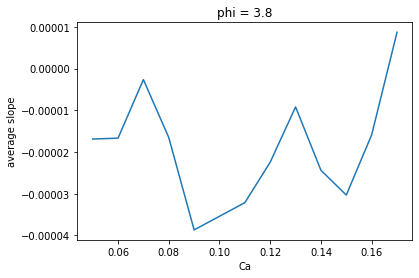

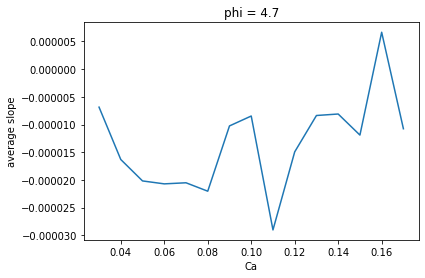

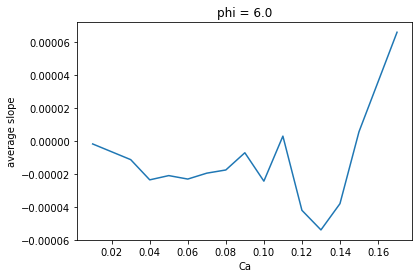

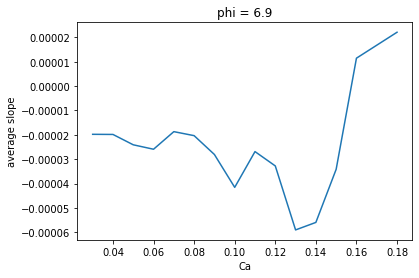

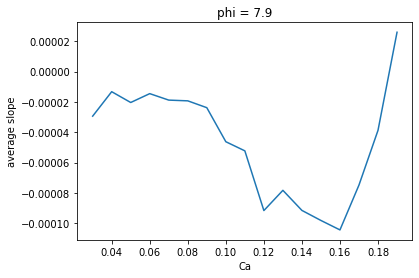

In [3]:
ncycle = 2000
r = 0.7
for phi in [3.8, 4.7, 6.0, 6.9, 7.9]:
    avg_m = []
    std_m = []
    Cas = []
    for i in range(20):
        Ca = 0.01*(i+1)
        m_Ca = []
        for j in range(18):
            angle = 90 - 10*j
            ms = slope()
            if ms[0] == 1:
                #print("phi = {}, Ca = {}, angle = {}\n m_avg = {}, m_max = {}".format(phi, Ca, angle, ms[1], ms[2]))
                m_Ca.append(ms[2])
        if len(m_Ca) > 0:
            Cas.append(Ca)
            avg_m.append(np.mean(m_Ca))
            std_m.append(np.std(m_Ca))
    plt.figure()
    plt.plot(Cas, avg_m)
    plt.title("phi = {}".format(phi))
    plt.xlabel('Ca')
    plt.ylabel("average slope")
    plt.show()

## elastic stress zz, doublet fraction vs time plots

In [78]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def plot_three_variables(plot_or_not):
    start_time_step = 10
    fig, host = plt.subplots(figsize = (12, 9))
    fig.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()
    par2.spines["right"].set_position(("axes", 1.1))
    make_patch_spines_invisible(par2)
    par2.spines["right"].set_visible(True)

    r = 0.6
    result = calcDoubletFraction(phi, Ca, 1.0, r, 0, angle)
    if (len(result[0][0])>2000):
        dfs = result[0][0][:ncycle]
        dfg = result[1][0][:ncycle]
    else:  
        dfs = result[0][0]
        dfg = result[1][0]
    simul_time = list(range(len(dfs)))
    end_time = len(dfs)
    start_time_step = 1000
    end_time = 1700
    #p1_1, = host.plot(simul_time[start_time_step:], dfg[start_time_step:], "b-", label = "General DF")
    #p1_2, = host.plot(simul_time[start_time_step:], dfs[start_time_step:], "b-", label = "Strict DF", linestyle = '--')
    p1, = host.plot(simul_time[start_time_step : end_time], result[0][0][start_time_step : end_time], "b-", label = "State")
    p2, = par1.plot(simul_time[start_time_step : end_time], getInstrinsicViscosity(phi, Ca, 0, ncycle, angle)[start_time_step : end_time], "r-", label = r'$\left[ \eta \right]$')
    p3, = par2.plot(simul_time[start_time_step : end_time], getStress(phi, Ca, 0, 0, ncycle, angle)[:,8][start_time_step : end_time], "g-", label = r'$\sigma _{elas, zz}$')

    host.set_title('phi = {}, Ca = {}, angle = {}\ncriteria r = {}Dm'.format(phi, Ca, angle, r), fontsize = 30)
    host.set_xlabel("timesteps(strain)", fontsize = 20)
    host.set_ylabel("Doublet fraction", fontsize = 20)
    par1.set_ylabel(r'$\left[ \eta \right]$', fontsize = 20)
    par2.set_ylabel(r'$\sigma _{elas, zz}$', fontsize = 20)

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=6, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    lines = [p1, p2, p3]
    host.legend(lines, [l.get_label() for l in lines], prop={'size': 12}, bbox_to_anchor=(1.1,1.2))
    fig.tight_layout()
    if plot_or_not == 0:
        plt.close()
    elif plot_or_not == 1:
        plt.savefig('./Pictures/TwoCellSystem_Elastic_stress_zz_timeseries_phi_{}_Ca_{}_angle_{}_r_{}.png'.format(phi, Ca, angle, r), dpi = 300)
    
    return np.mean(dfg)

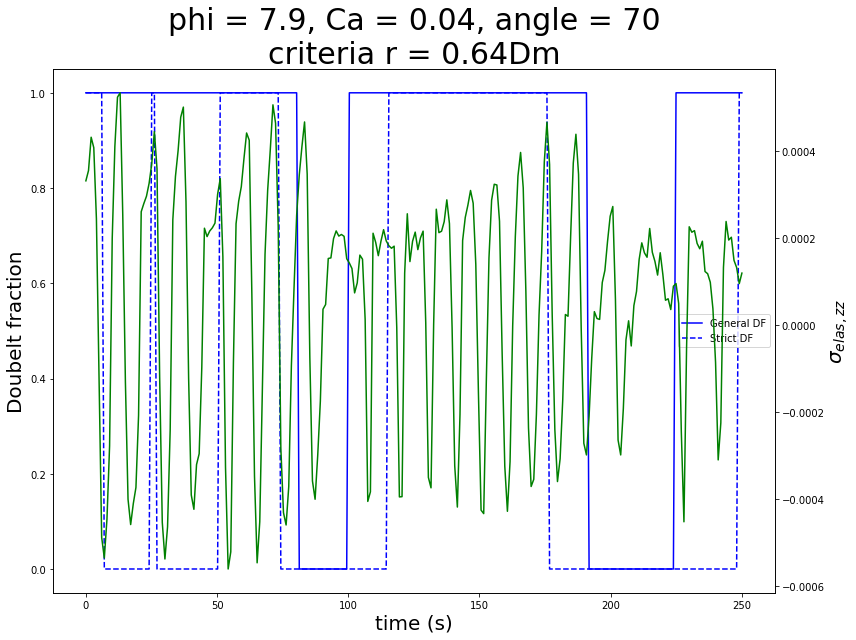

Total time elapsed = 0:00:00.351851


In [5]:
start_time = time.time()

r = 0.64 # criteria for inter-particle distance
ncycle = 2000
phi, Ca, angle = 7.9, 0.04, 70
result = calcDoubletFraction(phi, Ca, 1.0, r, 0, angle)

st, et = 0, 250

dfs = result[0][0][st:et]
dfg = result[1][0][st:et]
stress = getStress(phi, Ca, 0, 0, ncycle, angle)[:,8][st:et]
t = np.linspace(st, et, et-st)


fig, ax1 = plt.subplots(figsize=(12,9))

ax1.set_xlabel('time (s)', fontsize = 20)
ax1.set_ylabel('Doubelt fraction', fontsize = 20)
ax1.plot(t, dfg, "b-", label = "General DF")
ax1.plot(t, dfs, "b-", label = "Strict DF", linestyle = '--')
ax1.tick_params(axis='y')
ax1.set_title('phi = {}, Ca = {}, angle = {}\ncriteria r = {}Dm'.format(phi, Ca, angle, r), fontsize = 30)
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel(r'$\sigma _{elas, zz}$', fontsize = 20)  # we already handled the x-label with ax1
ax2.plot(t, stress, "g-", label = r'$\sigma _{elas, zz}$')
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Total time elapsed = {}'.format(str(datetime.timedelta(seconds=time.time()-start_time))))

## Distinguish the negatively and positively linear line

In [55]:
def zPos(input_phi, input_Ca, input_criteria_Ts, input_criteria_Dms, *input_others):
    phi = input_phi
    Ca = input_Ca
    D = 0
    eqWCA = 0.8
    Dm = 15.64
    criteria_Ts = input_criteria_Ts if type(input_criteria_Ts) is list else [input_criteria_Ts]
    criteria_Dms = input_criteria_Dms if type(input_criteria_Dms) is list else [input_criteria_Dms]
    
    # Two-cell system
    if len(input_others) > 0:
        WriteProps = 3669
        angle = input_others[0]
        ncycle = 2000
        job_name = "phi_{}_Re_0.1_Ca_{}_aggregation_1KT_ncycle_{}_np_2_angle_{}".format(phi, Ca, ncycle, angle)
    
    # Suspension system
    else:
        WriteProps = 2000
        job_name = "h24phi{}Re0.1Ca{}D{}eqWCA{}".format(phi, Ca, D, eqWCA)

    
    # Read the preprocessed files by mounting the folder in server, use eval() function
    ###########################################################################
    # Read the parameters
    with open("/Users/andrewliu/remote_disk/Data_Transfer/{}_parameter.txt".format(job_name)) as f:
        pre_parameters = f.readlines()
    timesteps = int((pre_parameters[pre_parameters.index("timesteps\n")+1])[:-1])
    particle_numbers = int((pre_parameters[pre_parameters.index("particle_numbers\n")+1])[:-1])
    points_per_particle = int((pre_parameters[pre_parameters.index("points_per_particle\n")+1])[:-1])
    
    dim = np.zeros(3, dtype = np.int32)
    # Two-cell system
    try:
        tmp_dim = eval((pre_parameters[pre_parameters.index("dim\n")+1])[:-1])
        for i in range(3):
            dim[i] = tmp_dim[i]
    # Suspension system
    except:
        for i in range(3):
            dim[i] = [144, 24, 144][i]
    

    # Read the position of center of mass
    COMs = np.load("/Users/andrewliu/remote_disk/Data_Transfer/{}_COMs.npy".format(job_name))
    return [COMs, dim[2]]

## elastic stress zz plots

In [64]:
def state_stat_2(time_window, k):
    start_timestep = 10
    state = calcDoubletFraction(phi, Ca, 1.0, r, 0, angle)[3][0][:2000] # end at 2000 if the total number of timesteps exceeds 2000
    end_timestep = len(state)
    iv = getInstrinsicViscosity(phi, Ca, 0, ncycle, angle)[:end_timestep]
    stress = getStress(phi, Ca, 0, 0, ncycle, angle)[:,8][:end_timestep]
    indices = [[], [], []]
    stat = np.zeros((3, 3)) # first line indicates where the state appears in this case
    
    ## For distinguish the positively and negatively linear line
    [pos, dim_z] = zPos(phi, Ca, 1.0, r, angle)
    d_count, in_range_count = 0, 0
    
    # calculate the stat
    # initialization the count
    count = np.zeros(4)
    half_width = int(time_window/2)
    t = start_timestep + half_width
    for i in range(start_timestep, start_timestep + time_window):
        count[state[i]-1] += 1
    for j in range(3):
        if (count[j]/time_window > k):
            indices[j].append(t)
    
    for t in range(start_timestep + half_width + 1, end_timestep - half_width):
        count[state[t - half_width - 1] - 1] -= 1
        count[state[t + half_width] - 1] += 1
        for j in range(3):
            if (count[j]/time_window > k):
                indices[j].append(t)
                if j == 0:
                    d_count += 2
                    for particle_id in range(2):
                        if (pos[particle_id, t, 2] > 3) and (pos[particle_id, t, 2] < (dim_z-3)):
                            in_range_count += 1
 
    for i in range(3):
        if (len(indices[i]) == 0):
            stat[0, i] = 0
        else:
            stat[0, i] = 1
            stat[1, i] = np.mean(iv[indices[i]])
            stat[2, i] = np.mean(stress[indices[i]])           
    return [stat, in_range_count/d_count]

In [ ]:
start_time = time.time()

r = 0.6 # criteria for inter-particle distance
ncycle = 2000
time_window = 100
k = 0.8

total_iv_avgs = [[], [], []]
total_stress_avgs = [[], [], []]
total_iv_Cas = [[], [], []]
total_stress_Cas = [[], [], []]

# [9.9, 9.2, 7.9, 6.9, 6.0, 4.7, 3.8]
for phi in [3.8]:
    print(phi)
    ## Store stat for each phi
    iv_avgs = [[], [], []]
    stress_avgs = [[], [], []]
    iv_Cas = [[], [], []]
    stress_Cas = [[], [], []]
    
    for i in range(1, 3):
        Ca = i*0.01
        ## Store stat for each Ca
        tmp_iv_avgs = [[], [], []]
        tmp_stress_avgs = [[], [], []]
        for j in range(18):
            angle = 90-10*j
            result = state_stat(time_window, k)
            print("phi = {}, Ca = {}, angle = {}".format(phi, Ca, angle))
            for l in range(3):
                if result[0, l] != 0:
                    tmp_iv_avgs[l].append(result[1,l])
                    tmp_stress_avgs[l].append(result[2,l])
        for j in range(3):
            iv_avgs[j].extend(tmp_iv_avgs[j])
            iv_Cas[j].extend([Ca for l in range(len(tmp_iv_avgs[j]))])
            stress_avgs[j].extend(tmp_stress_avgs[j])
            stress_Cas[j].extend([Ca for l in range(len(tmp_stress_avgs[j]))])

    total_iv_avgs.append(iv_avgs)
    total_stress_avgs.append(stress_avgs)
    total_iv_Cas.append(iv_Cas)
    total_stress_Cas.append(stress_Cas)
    
    name = ["doublet", "kayaking", "sliding"]
    plt.figure(figsize = (8, 6))
    for i in range(3):
        plt.plot(iv_Cas[i], iv_avgs[i], 'o', label = name[i])
    plt.legend()
    plt.xlabel("Ca", fontsize = 20)
    plt.ylabel(r'$\left[ \eta \right]$', fontsize = 20)
    plt.title("phi = {}, time window = {}, k = {}".format(phi, time_window, k), fontsize = 30)
    plt.tight_layout()
    plt.savefig("./Pictures/test1.png", dpi=300)
    #plt.savefig('./Pictures/TwoCellSystem_IntrinsicViscosity_Ca_revised_phi_{}_r_{}_timewindow_{}_k_{}.png'.format(phi, r, time_window, k), dpi = 300)
    plt.figure(figsize = (8, 6))
    for i in range(3):
        plt.plot(stress_Cas[i], stress_avgs[i], 'o', label = name[i])
    plt.legend()
    plt.xlabel("Ca", fontsize = 20)
    plt.ylabel(r'$\left[ \eta \right]$', fontsize = 20)
    plt.title("phi = {}, time window = {}, k = {}".format(phi, time_window, k), fontsize = 30)
    plt.tight_layout()
    plt.savefig("./Pictures/test2.png", dpi=300)

print('Total time elapsed = {}'.format(str(datetime.timedelta(seconds=time.time()-start_time))))

## Intrinsic viscosity only plots

/Users/andrewliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/Users/andrewliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/andrewliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To con

Total time elapsed = 0:00:43.418508


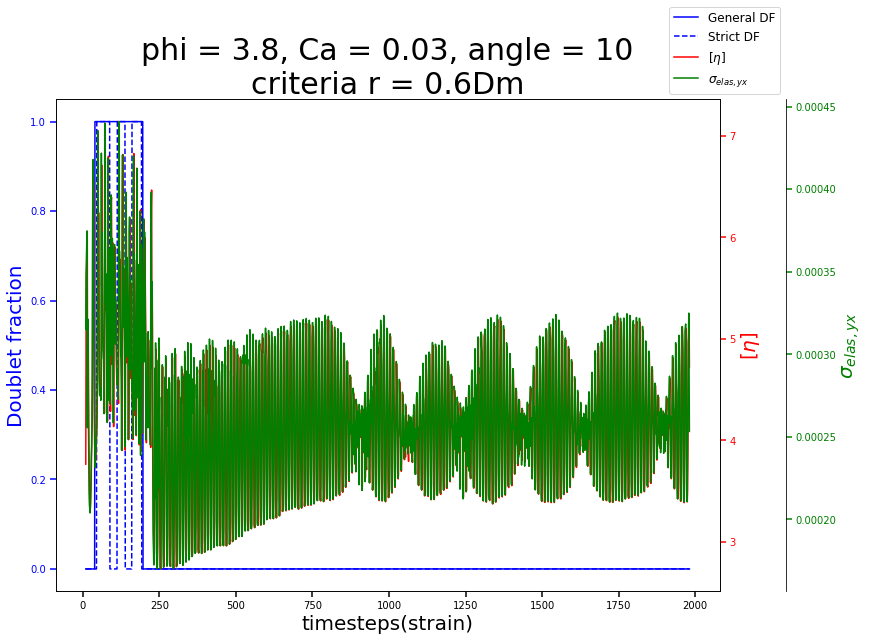

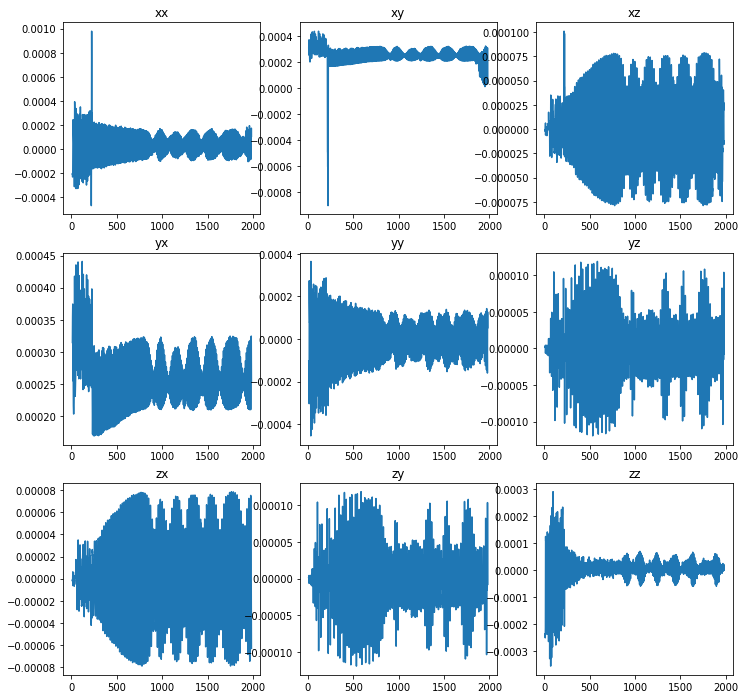

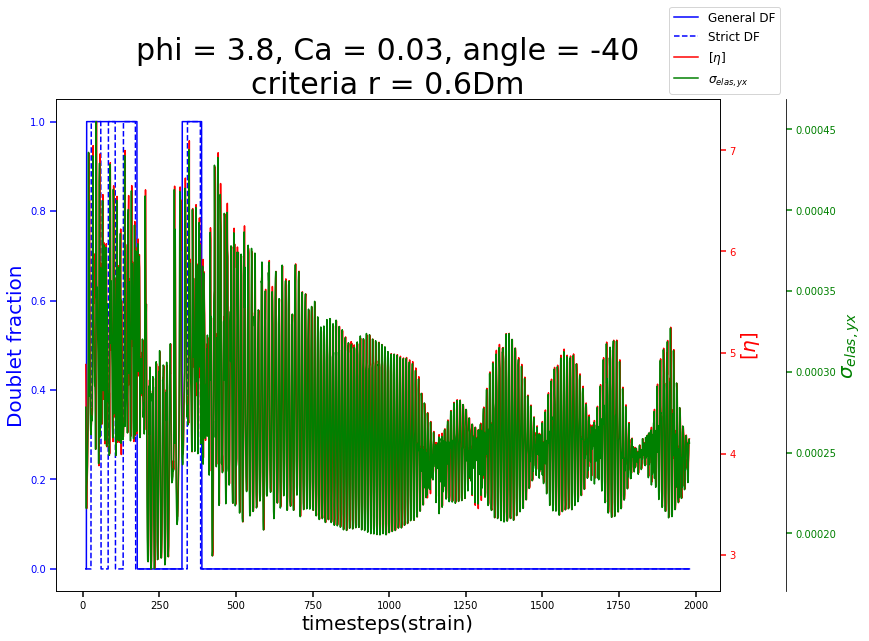

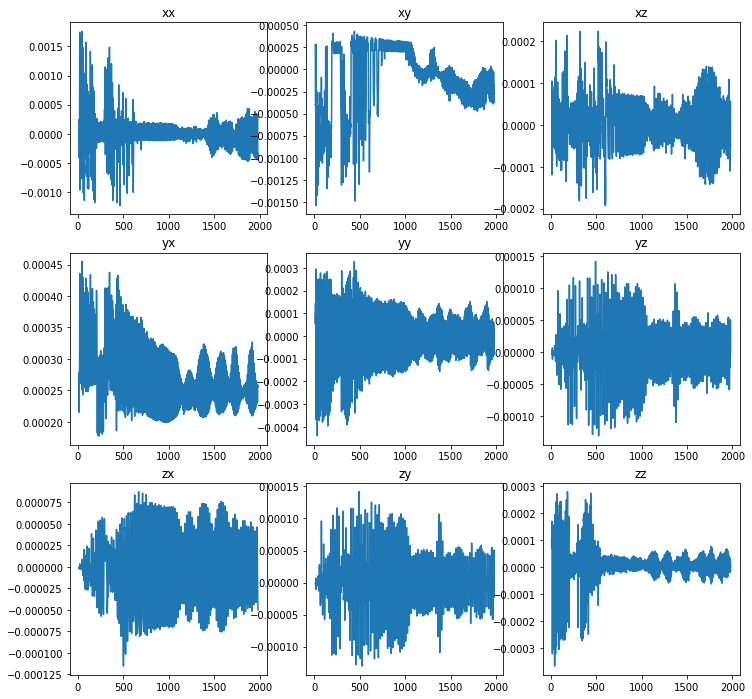

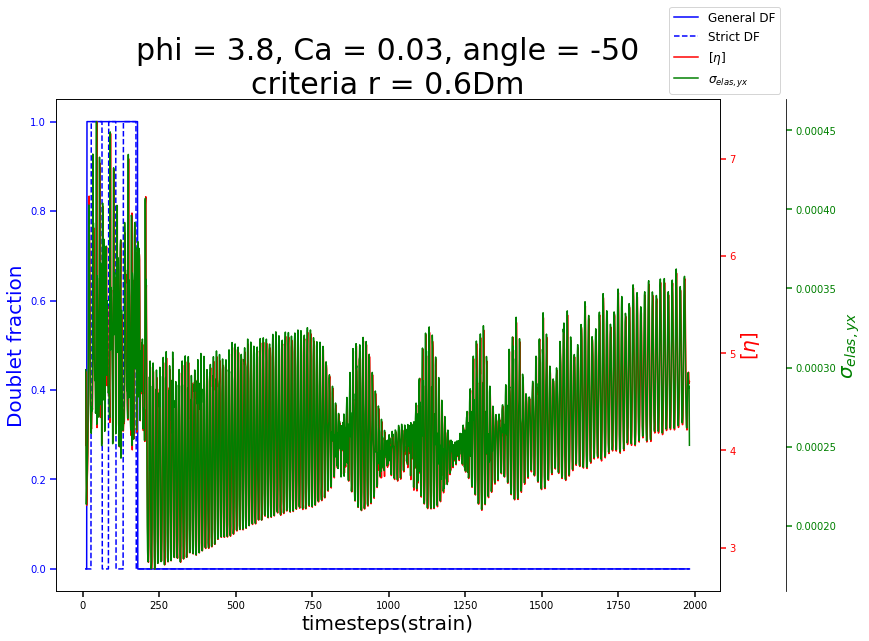

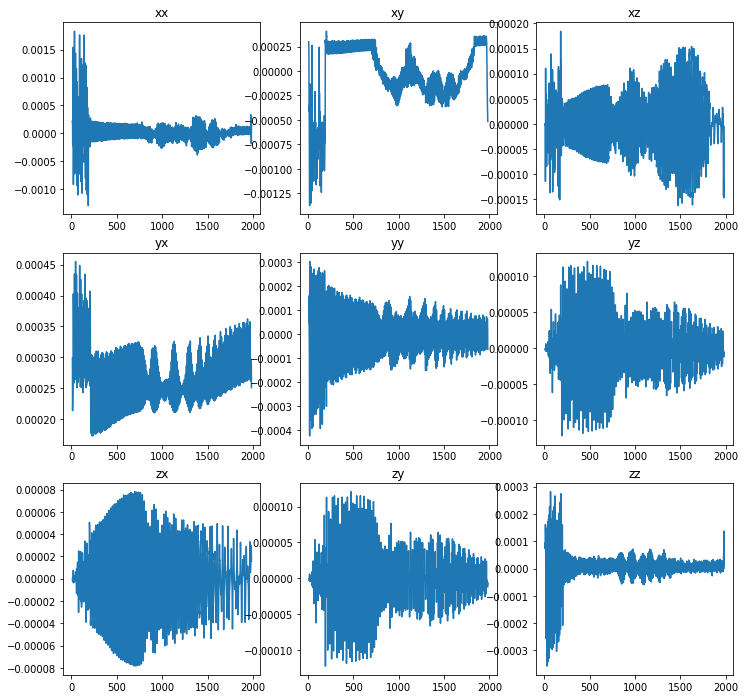

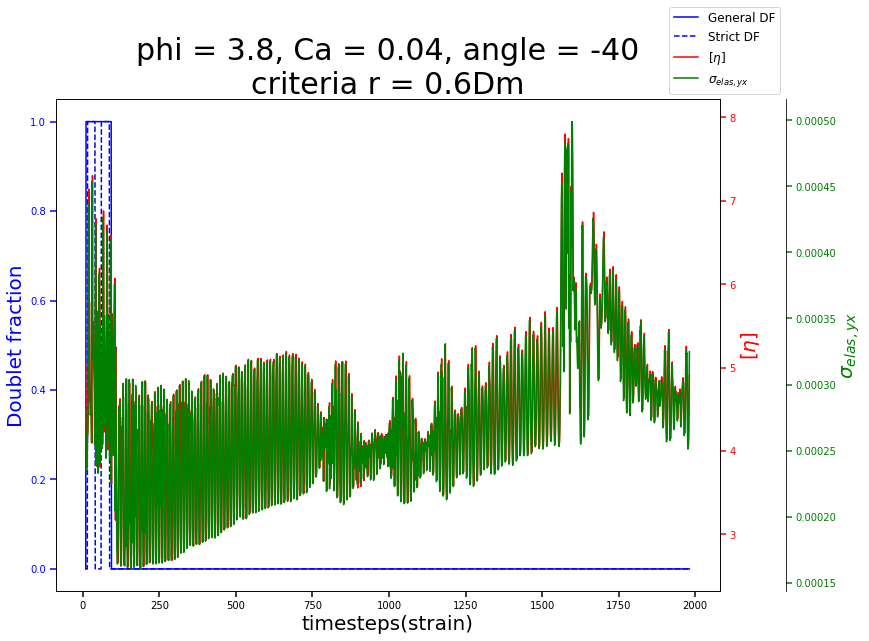

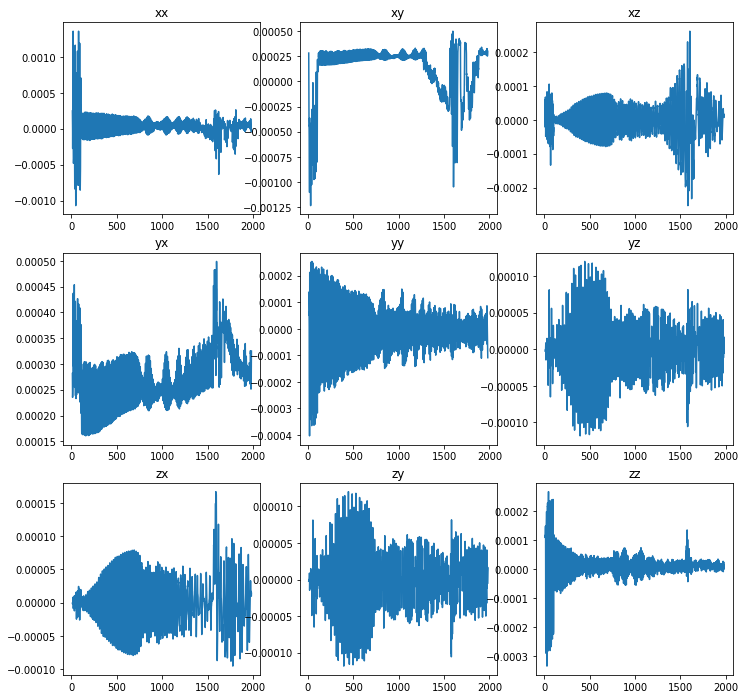

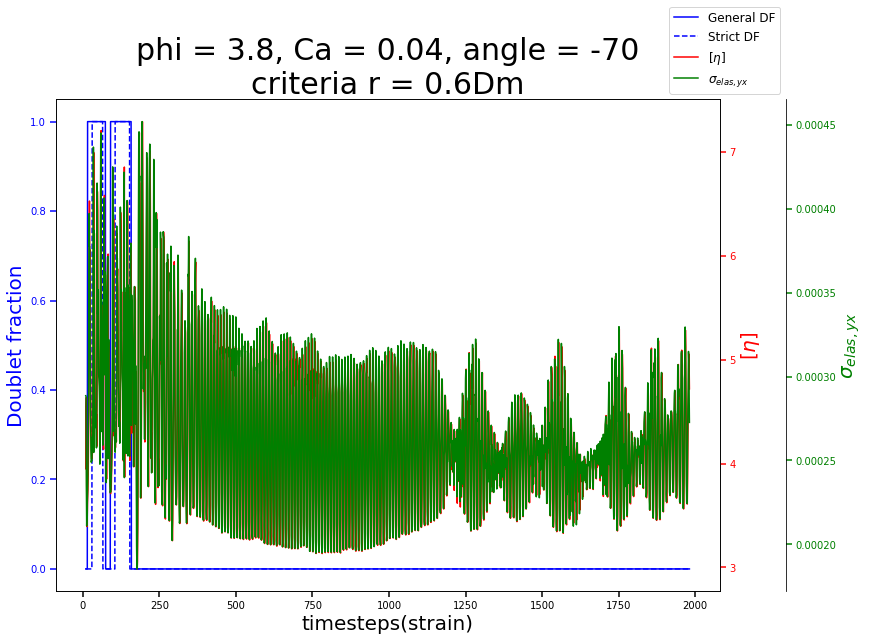

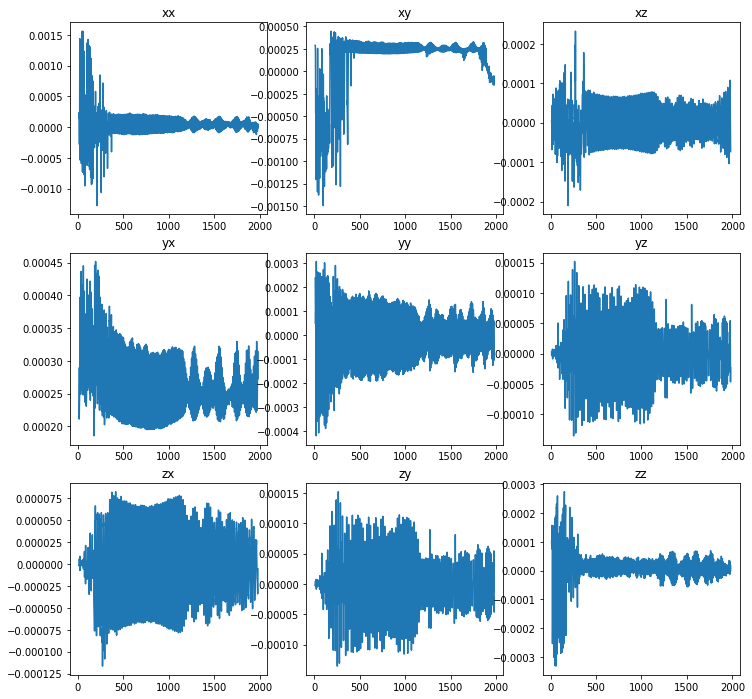

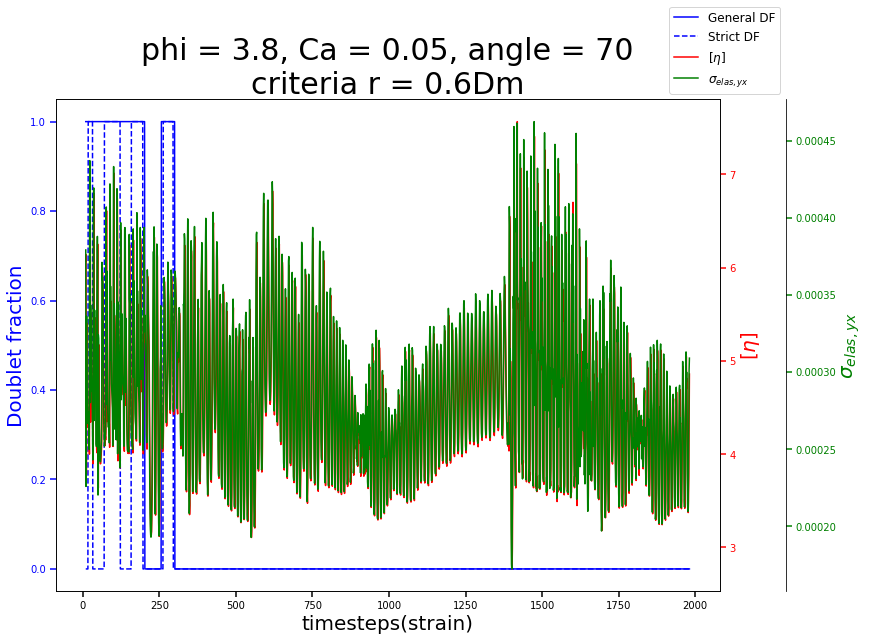

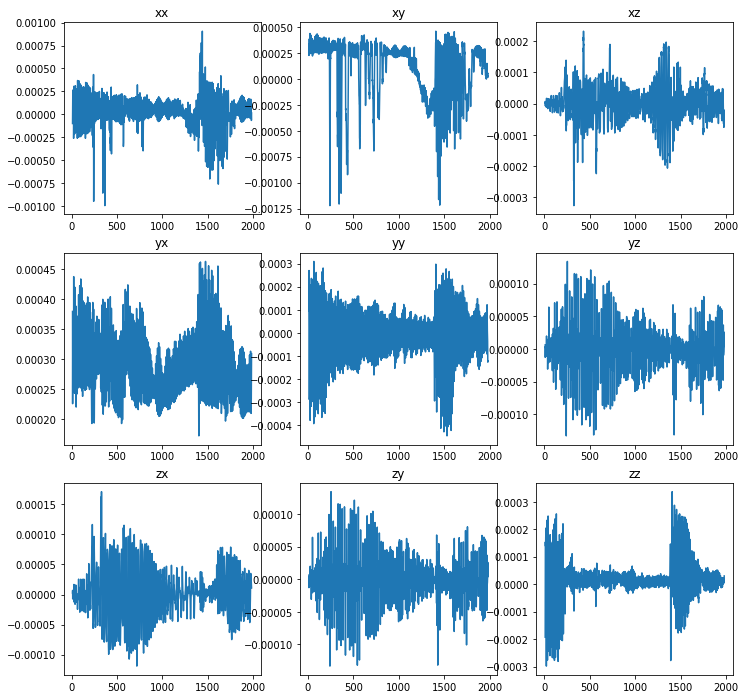

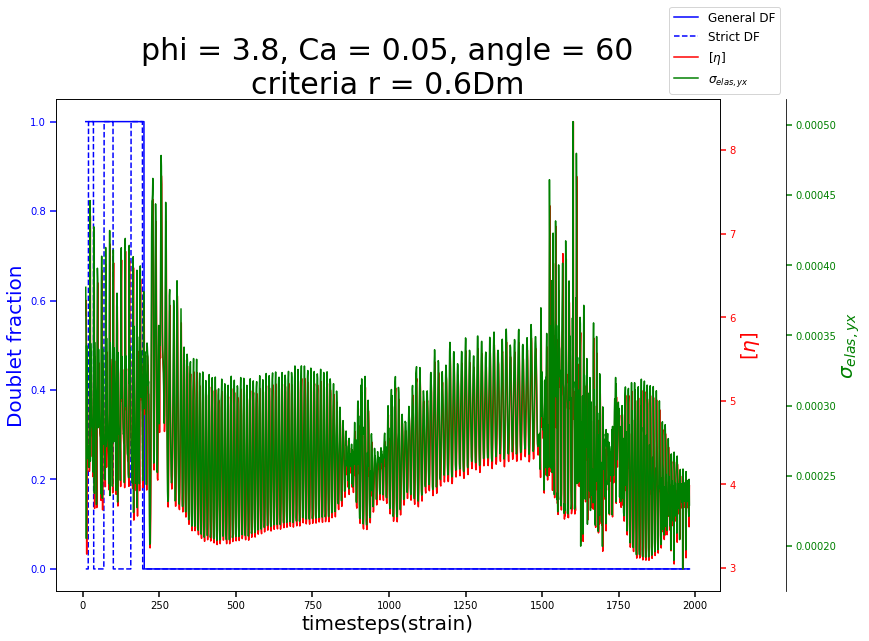

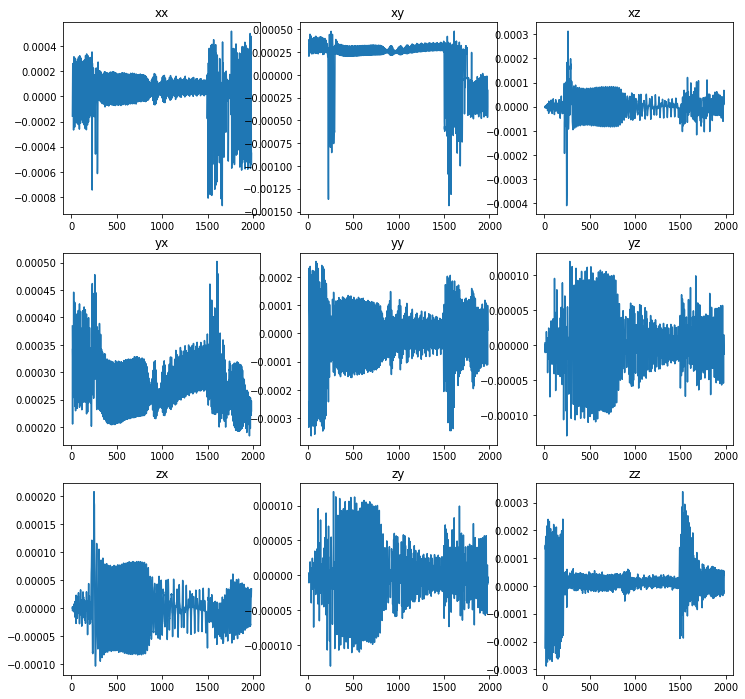

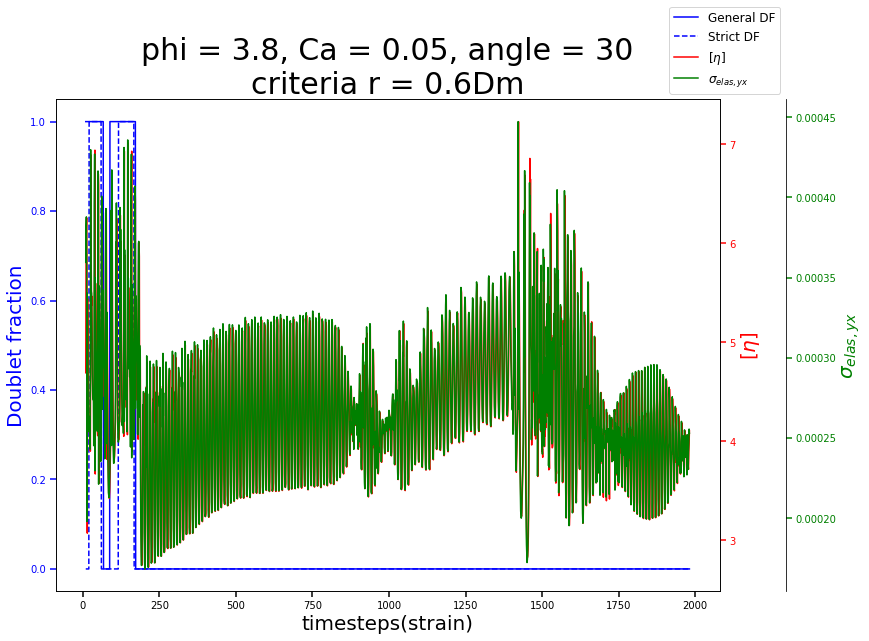

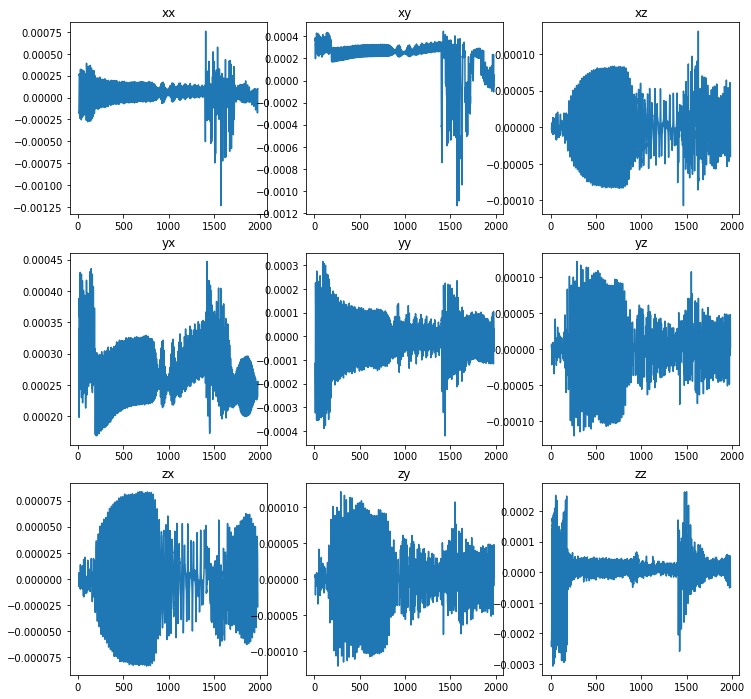

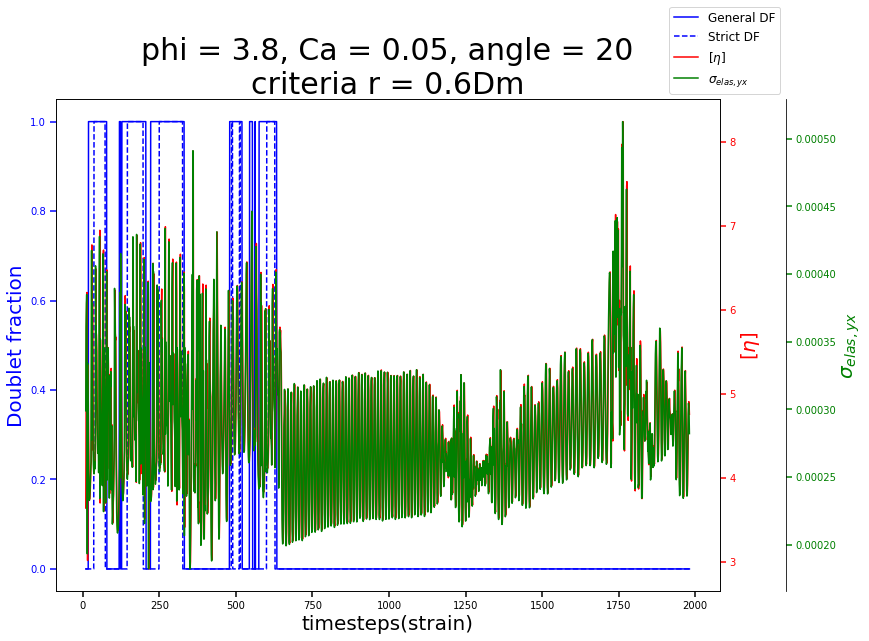

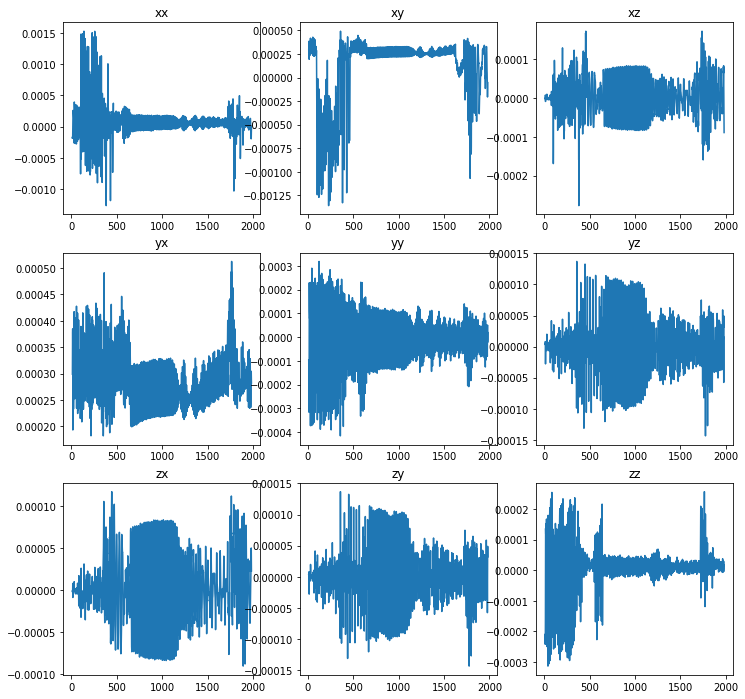

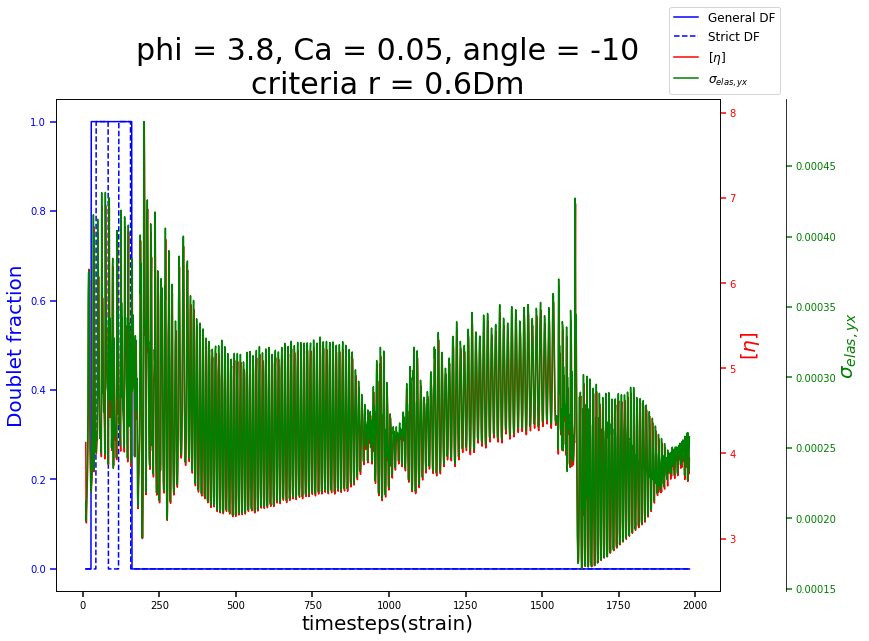

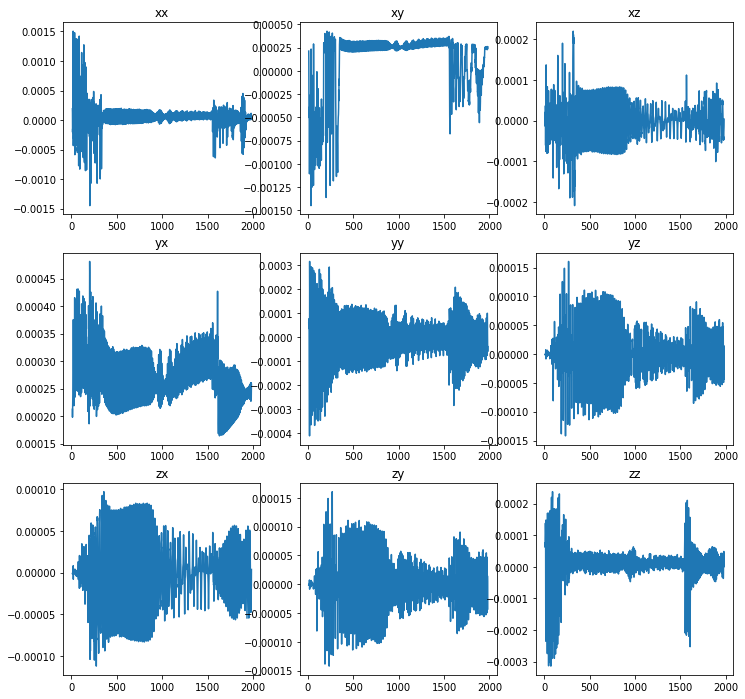

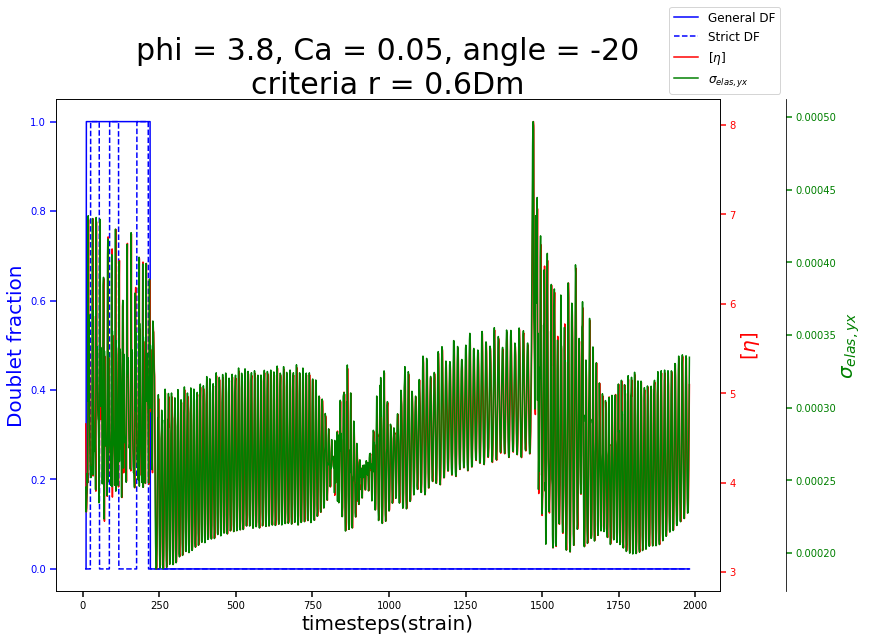

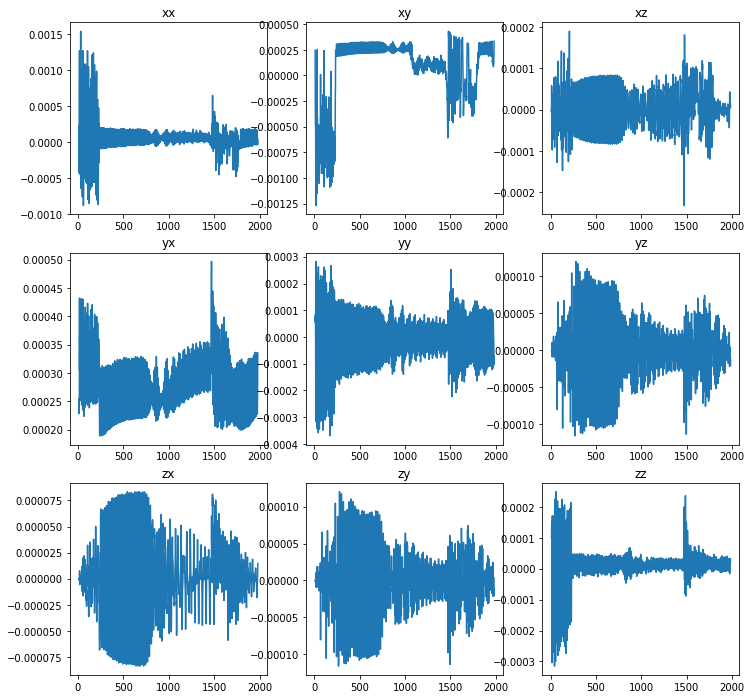

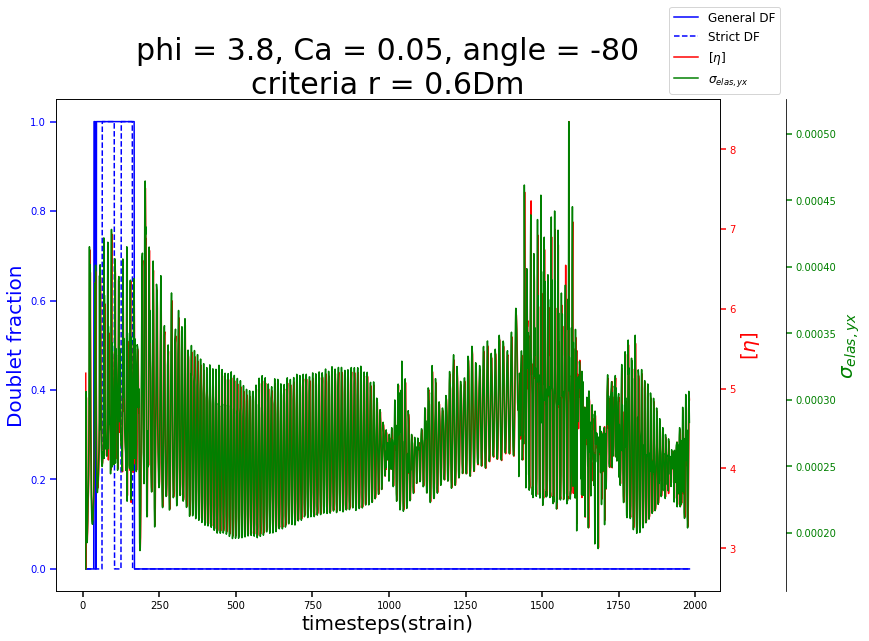

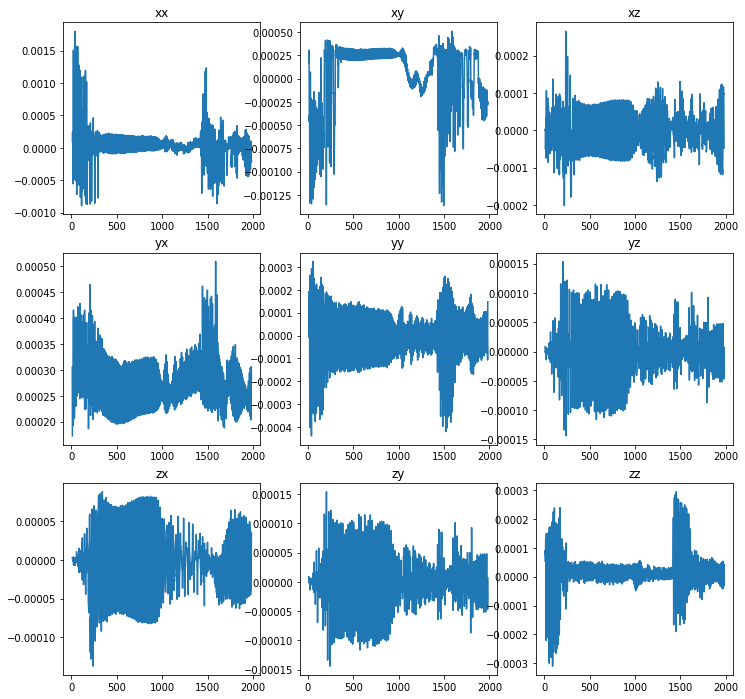

In [20]:
start_time = time.time()

r = 0.6 # criteria for inter-particle distance
ncycle = 2000
start_time_step = 10
time_window = 100
k = 0.8

# [9.9, 9.2, 7.9, 6.9, 6.0, 4.7, 3.8]
for phi in [3.8]:
    for i in range(3, 6):
        Ca = i*0.01
        for j in range(18):
            angle = 90-10*j
            result = avg_intrinsic(time_window, k)
            if result[0] != 0:
                plot_three_variables(2)              

print('Total time elapsed = {}'.format(str(datetime.timedelta(seconds=time.time()-start_time))))

/Users/andrewliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/Users/andrewliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/andrewliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To con

Total time elapsed = 0:01:05.139867


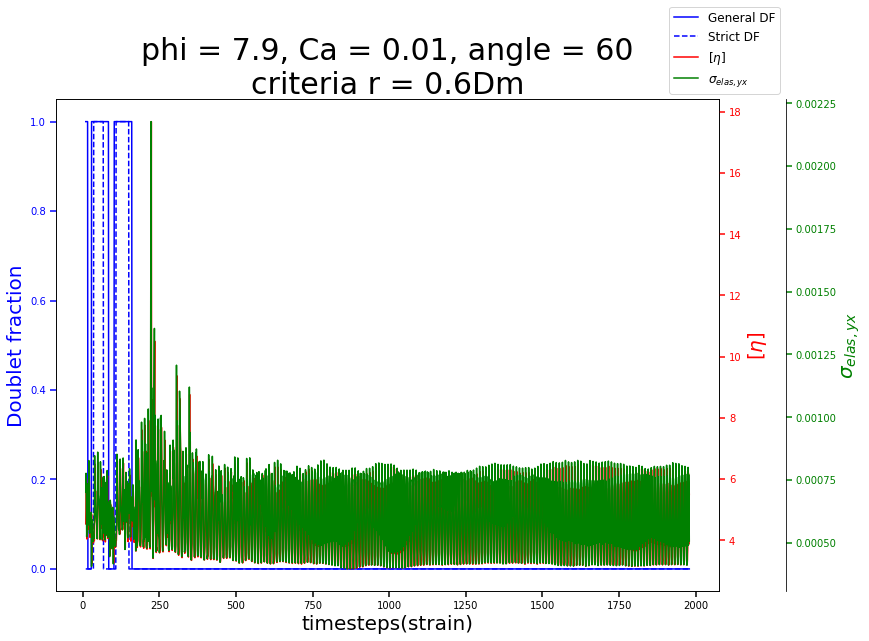

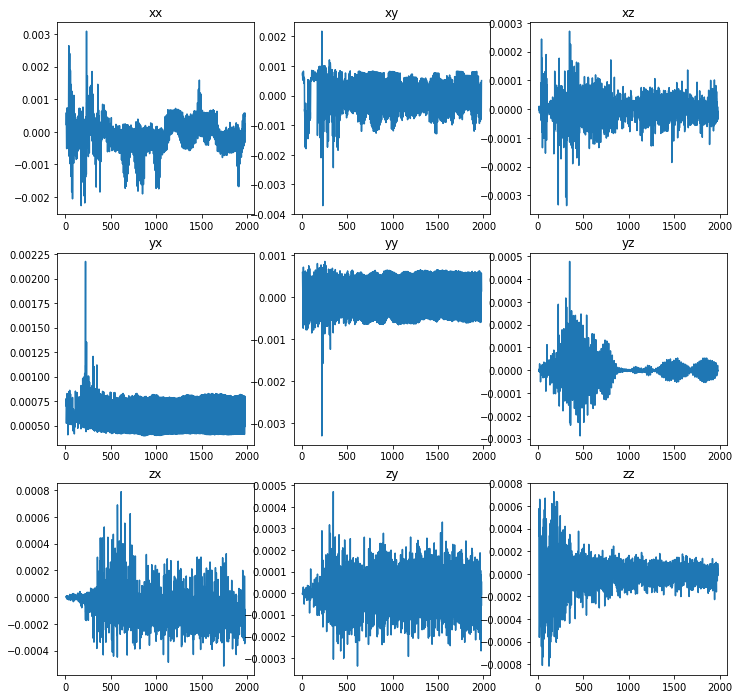

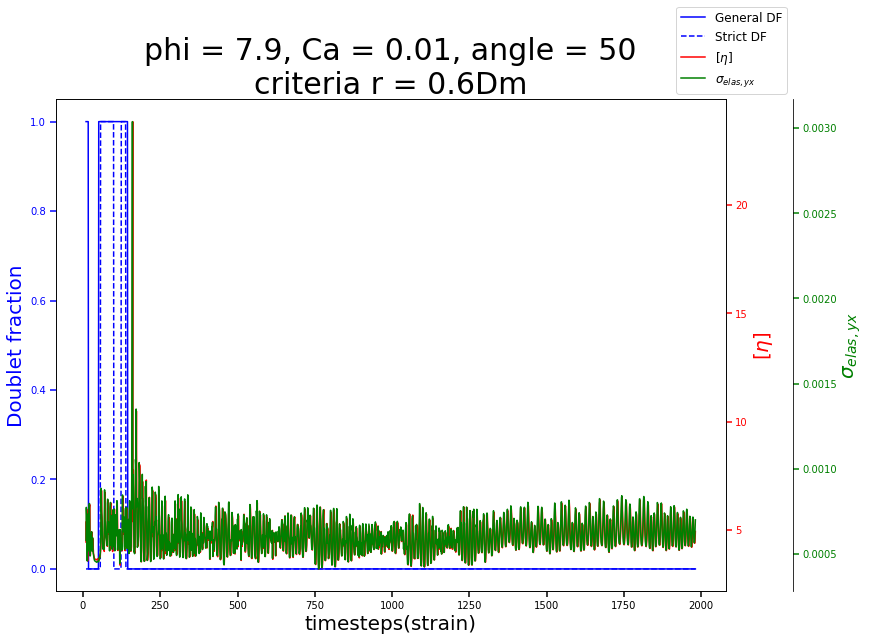

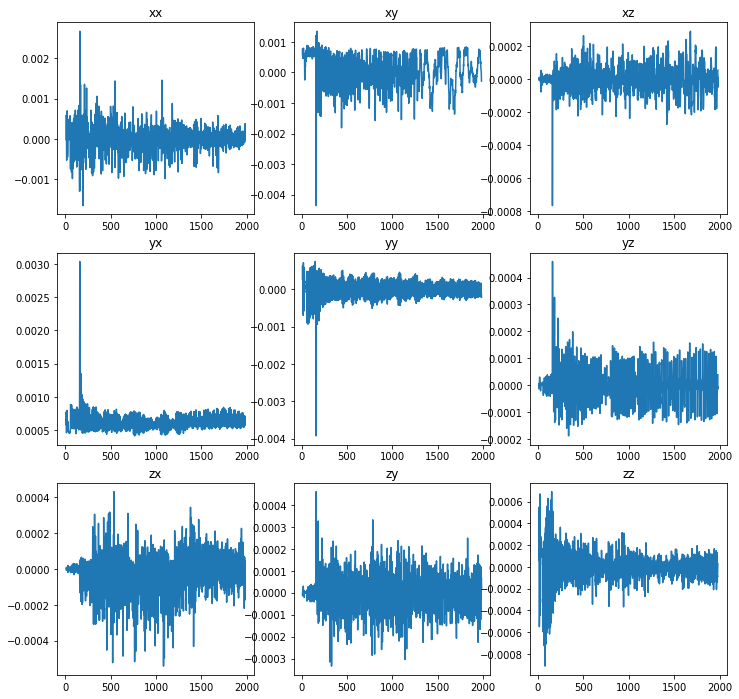

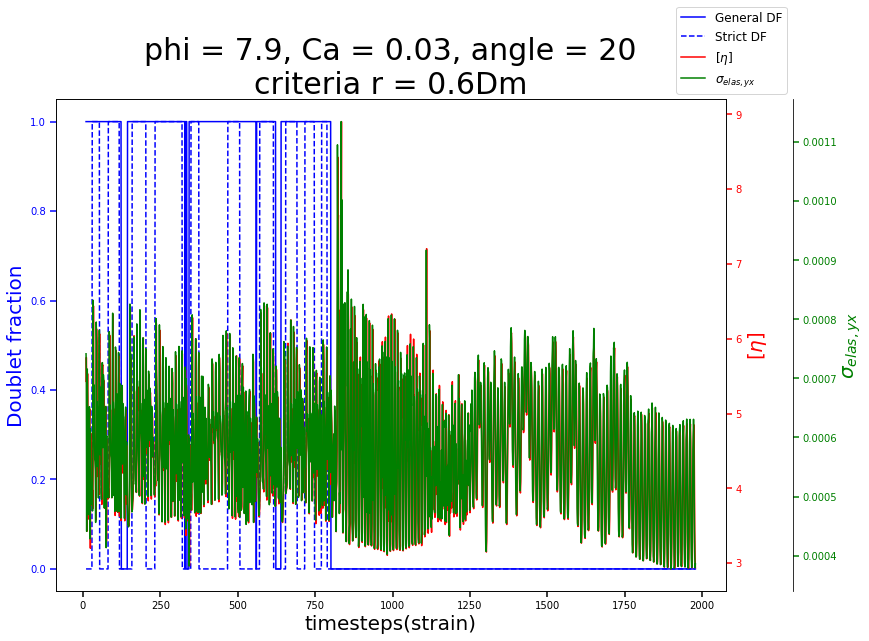

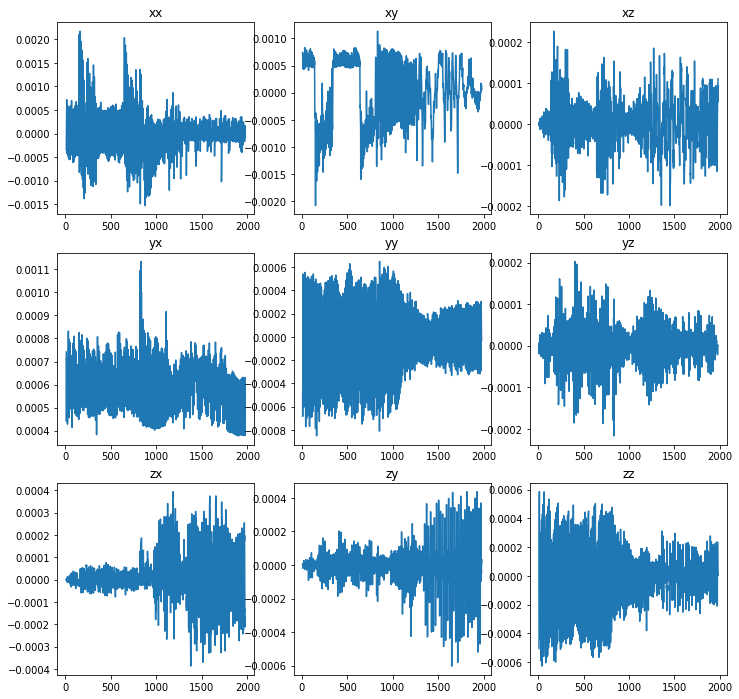

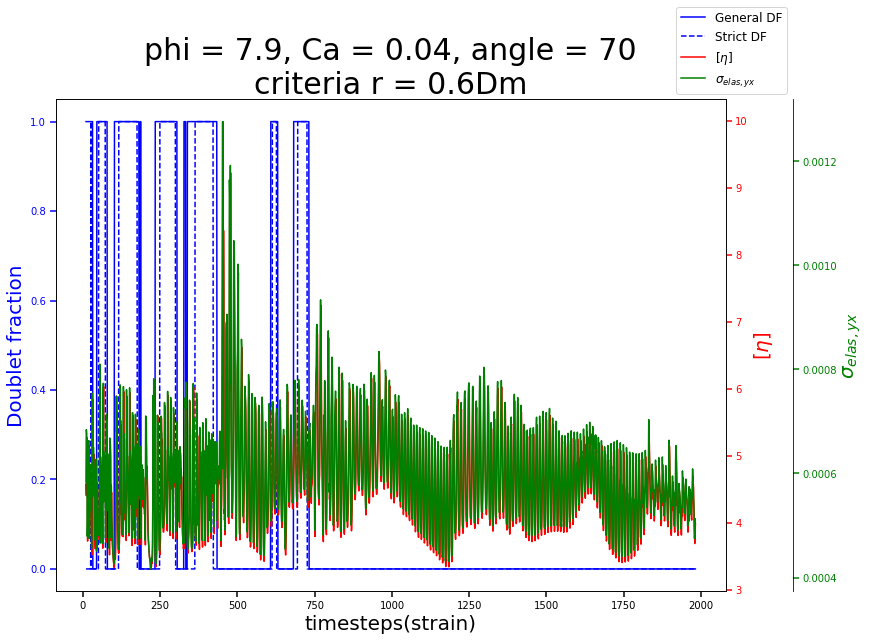

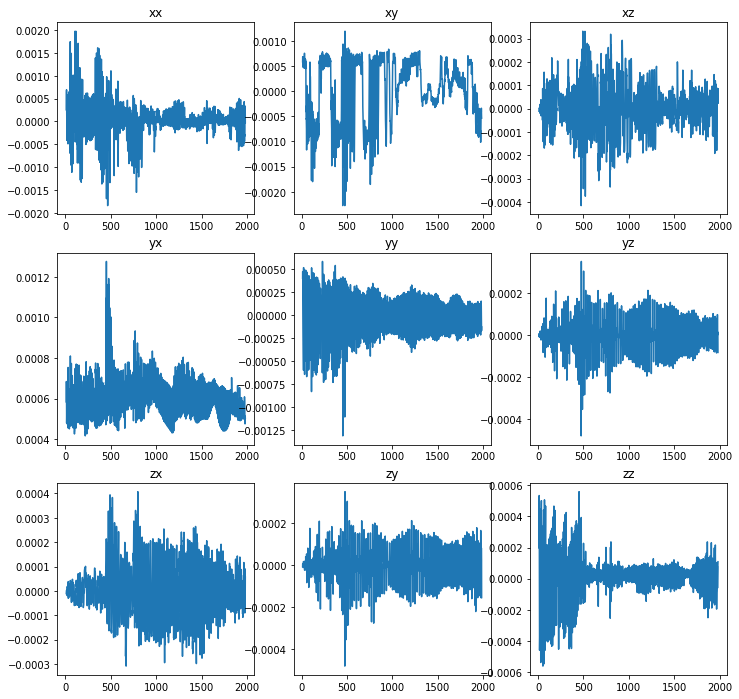

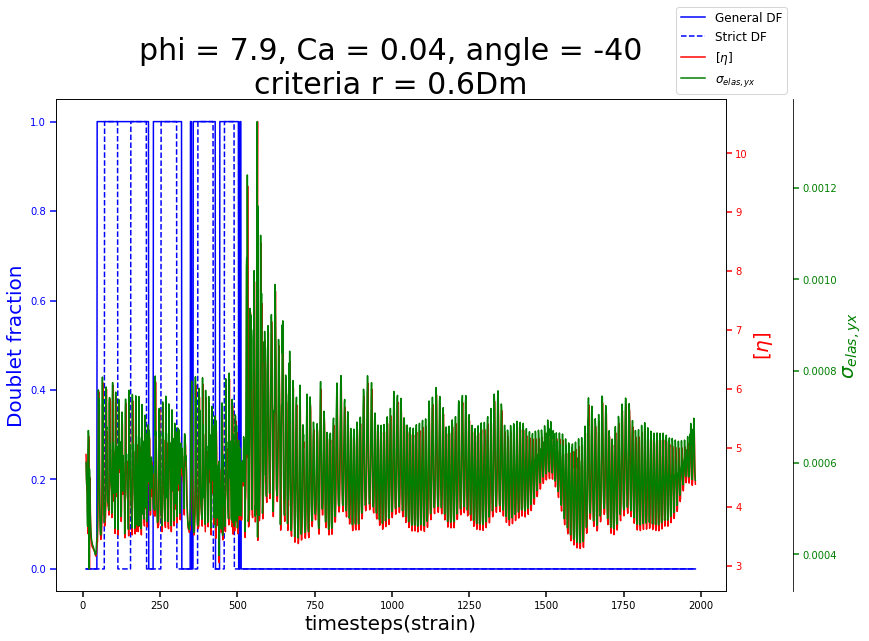

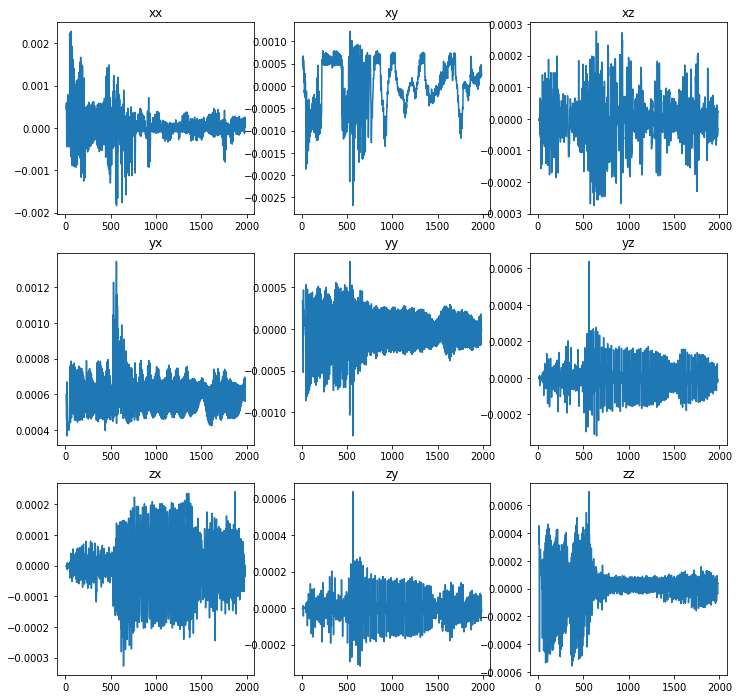

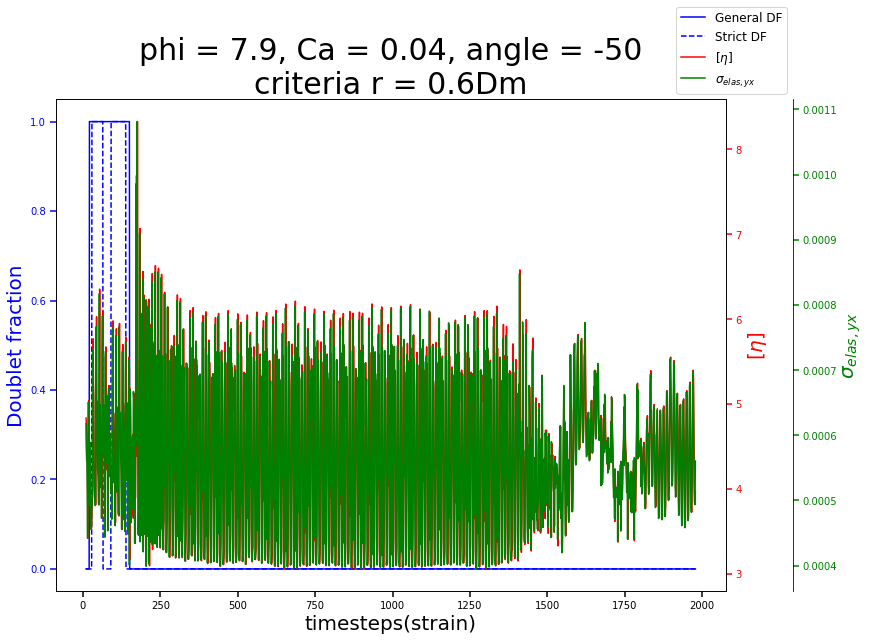

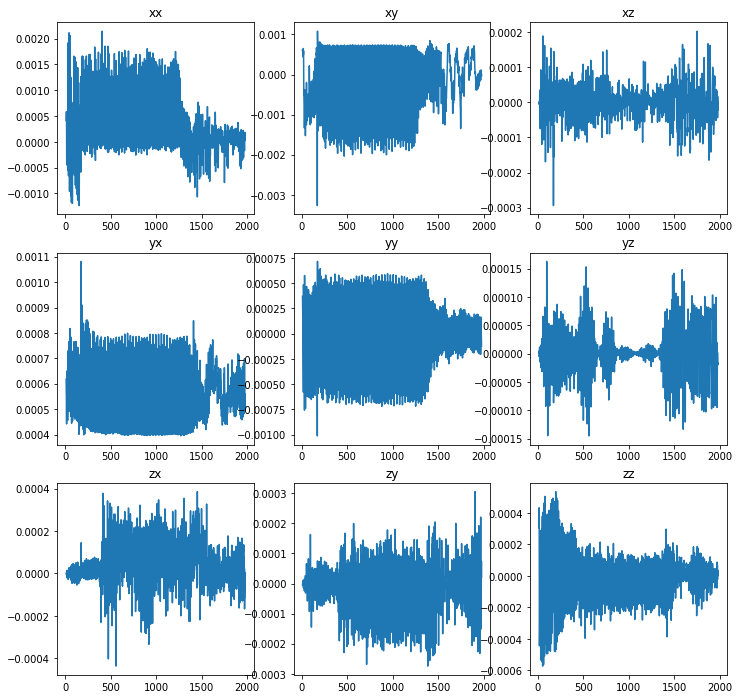

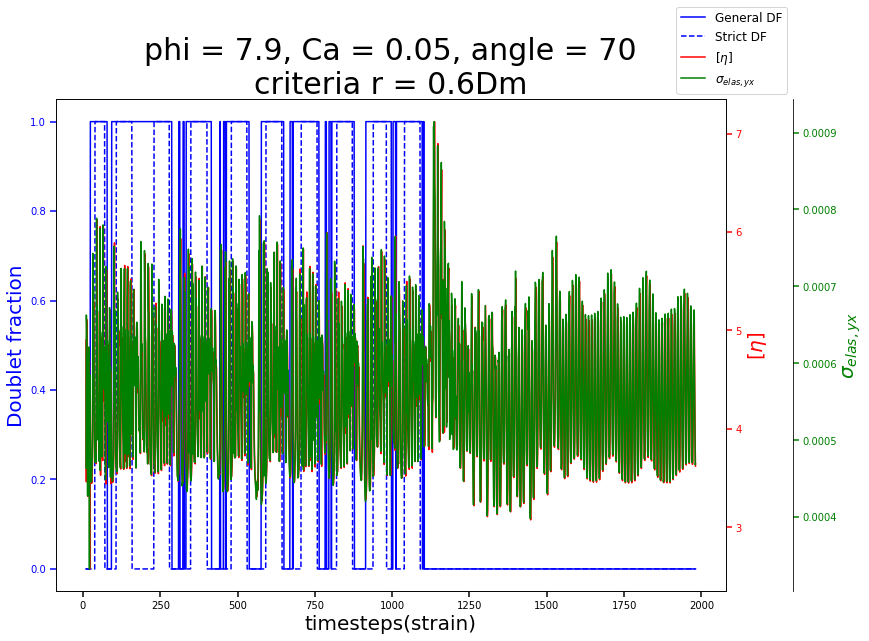

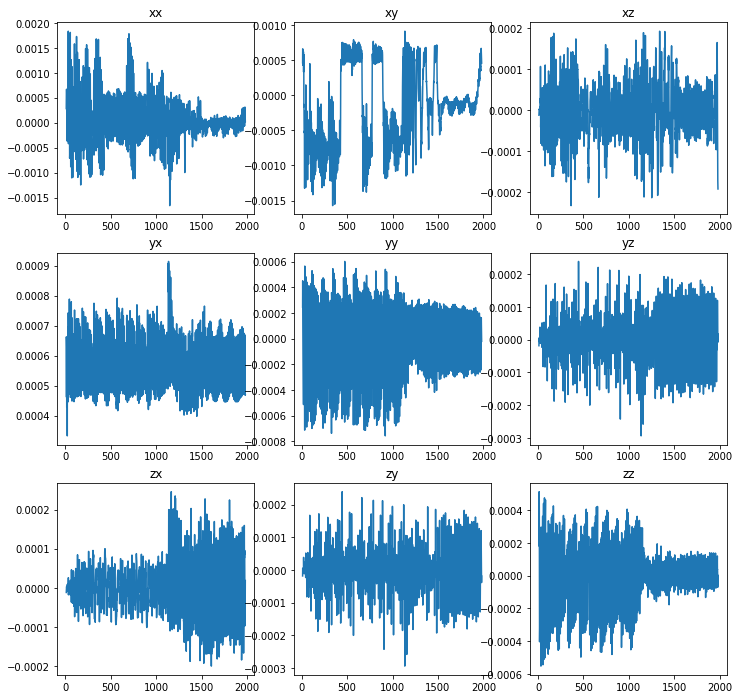

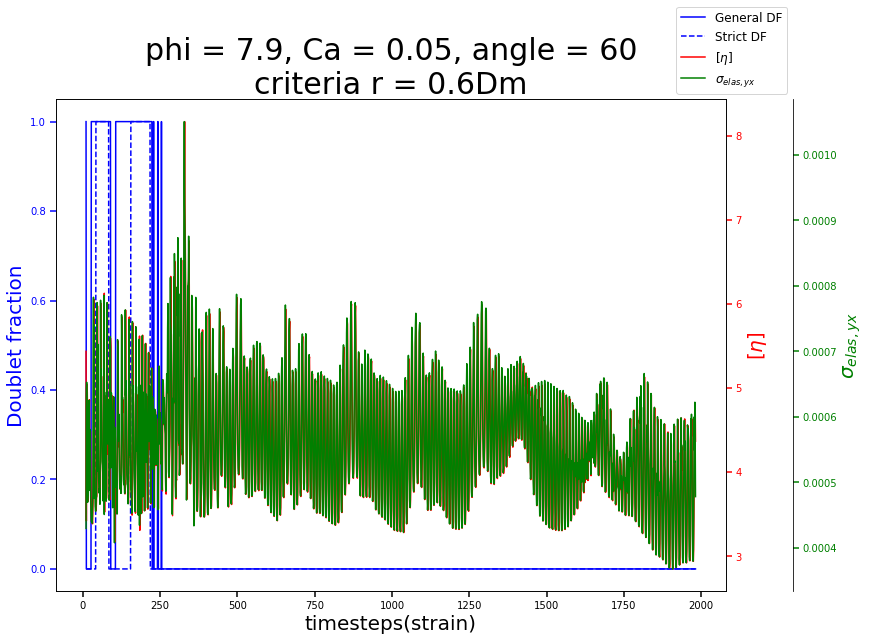

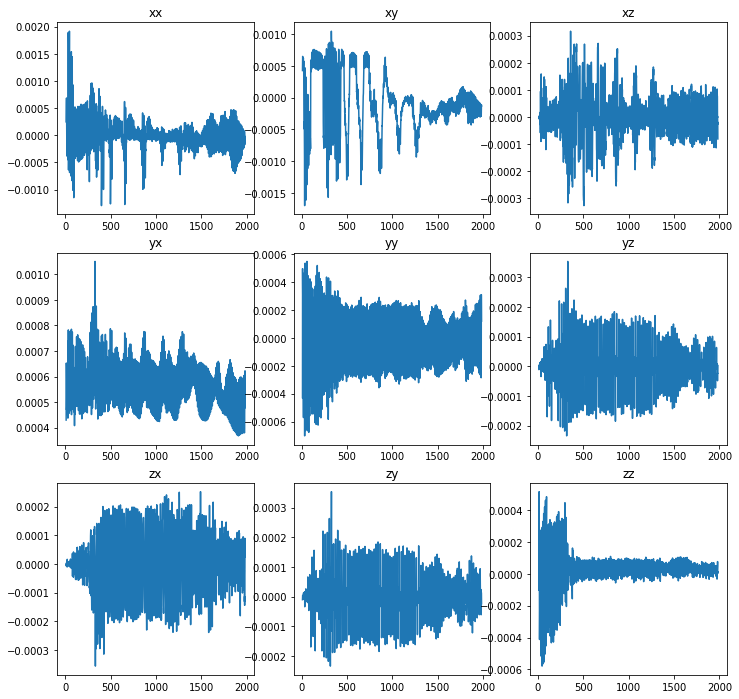

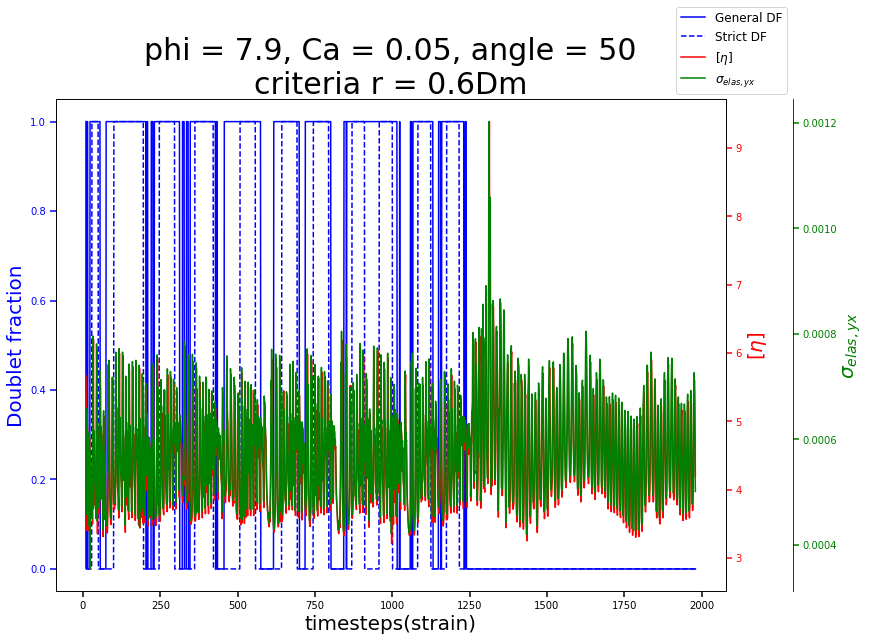

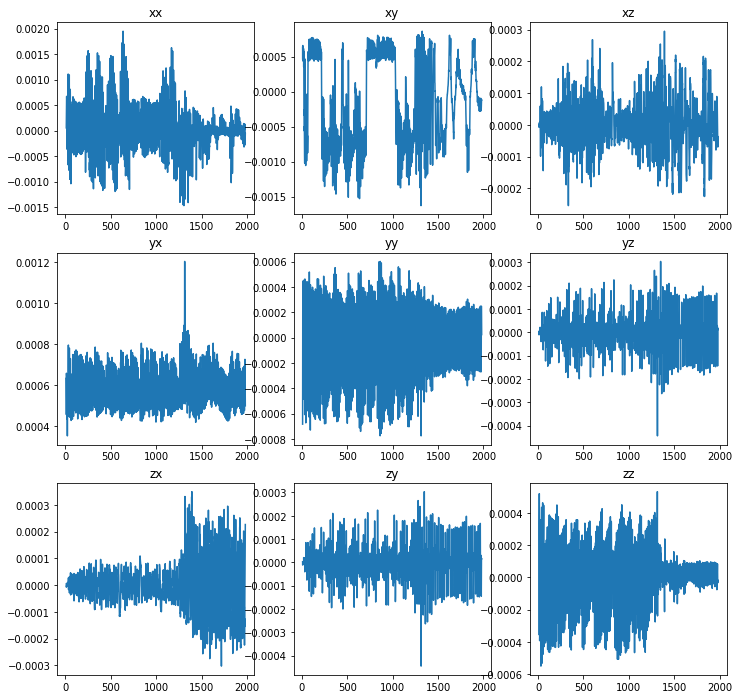

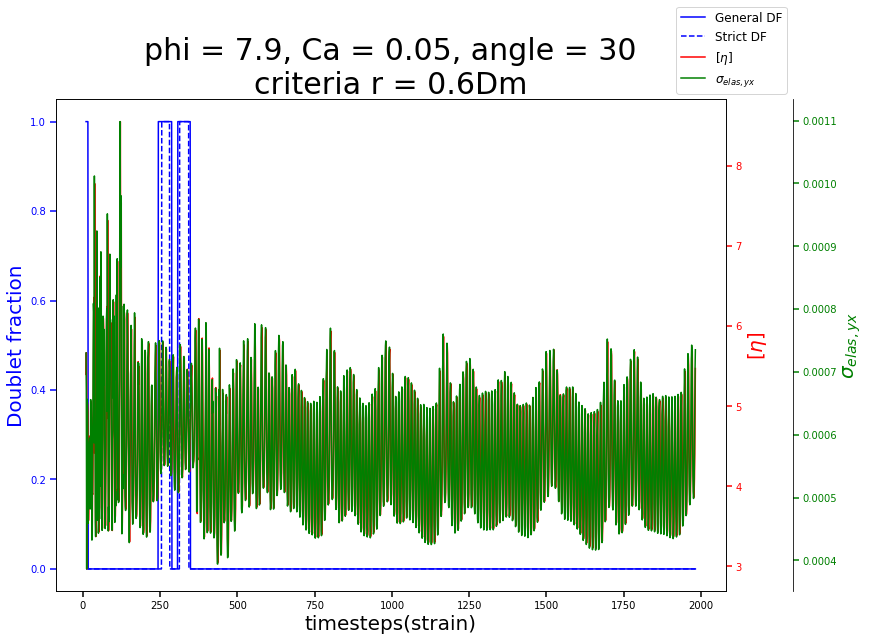

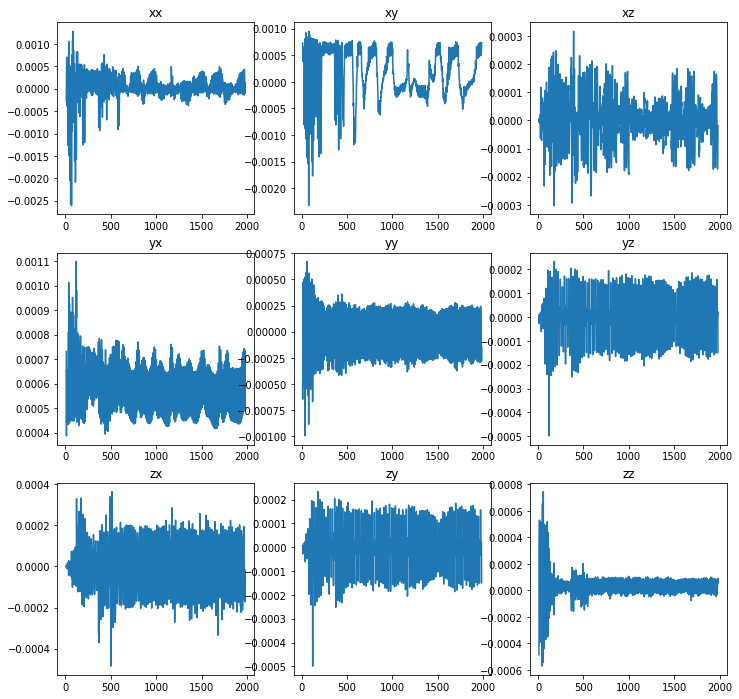

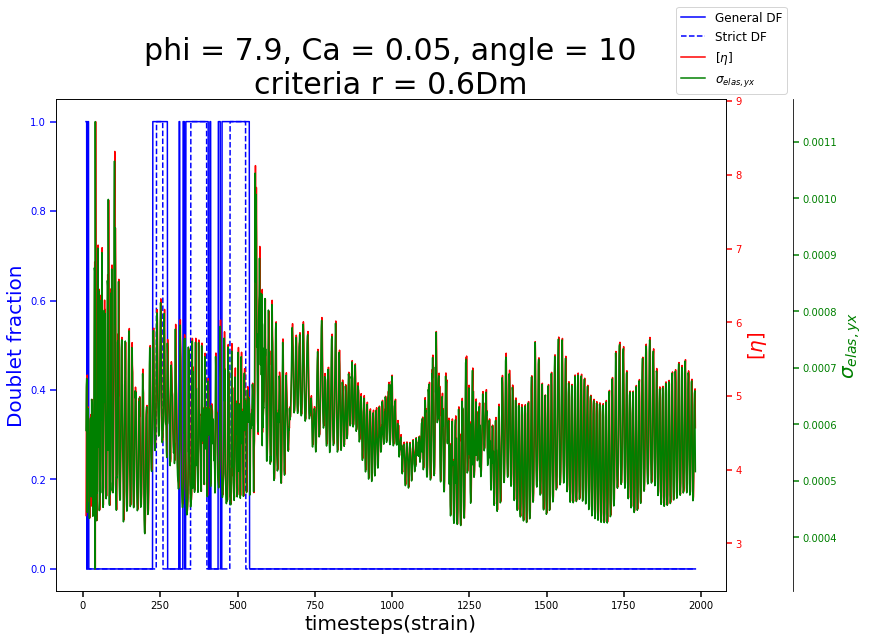

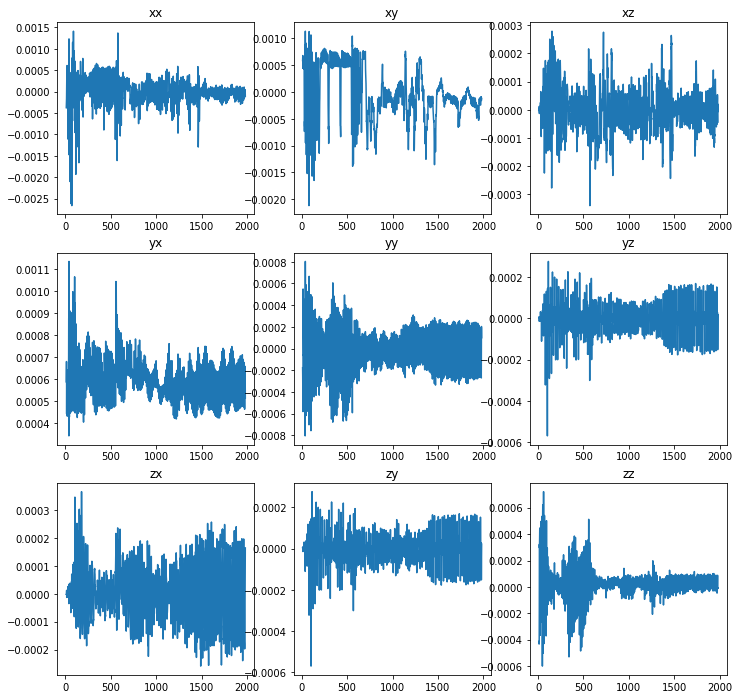

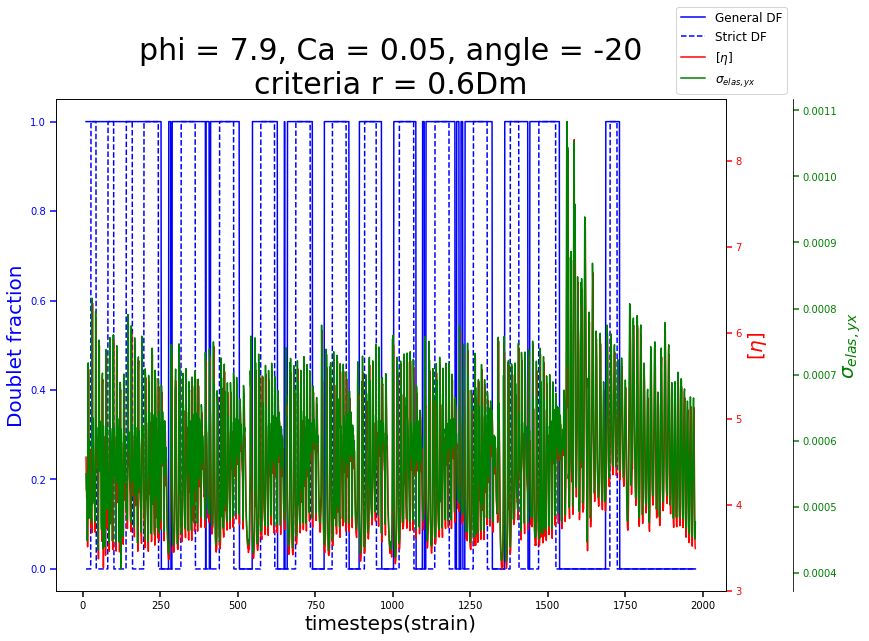

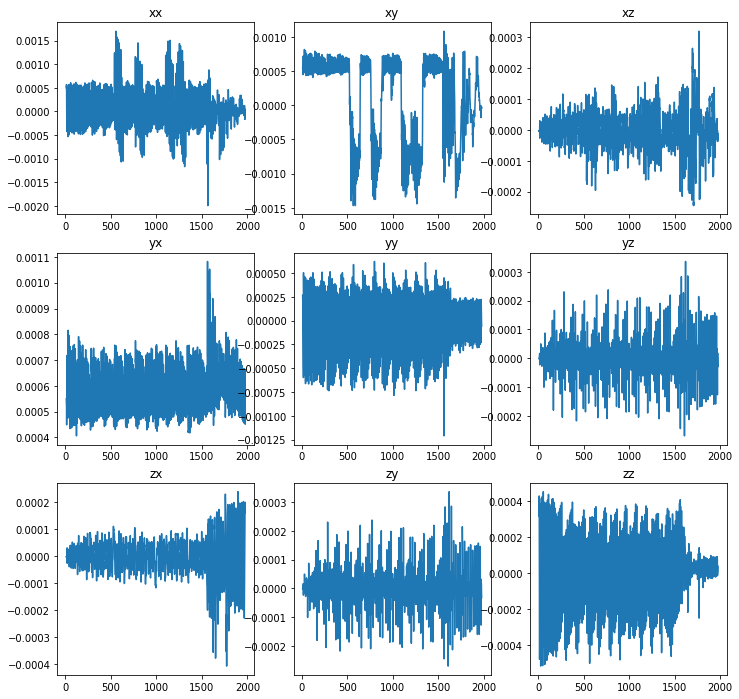

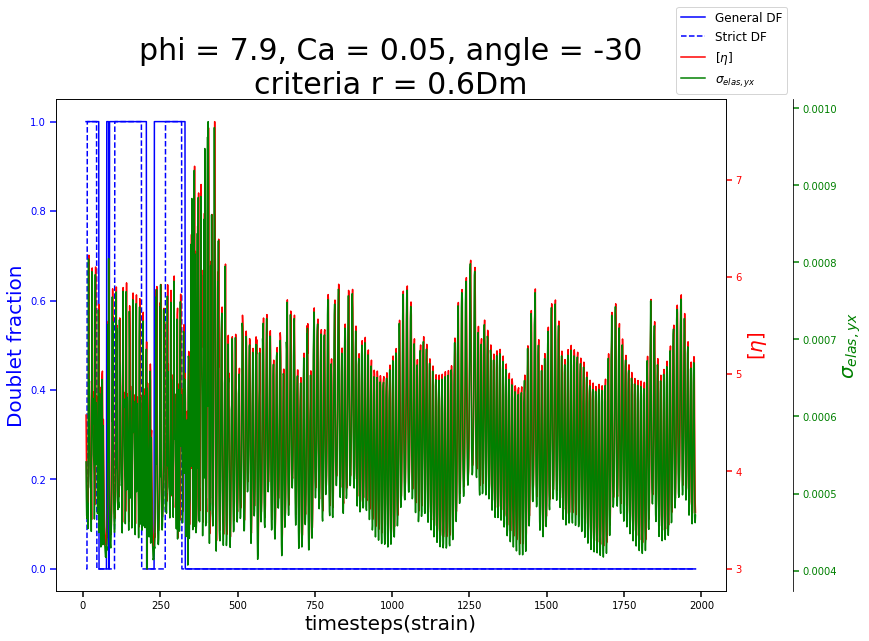

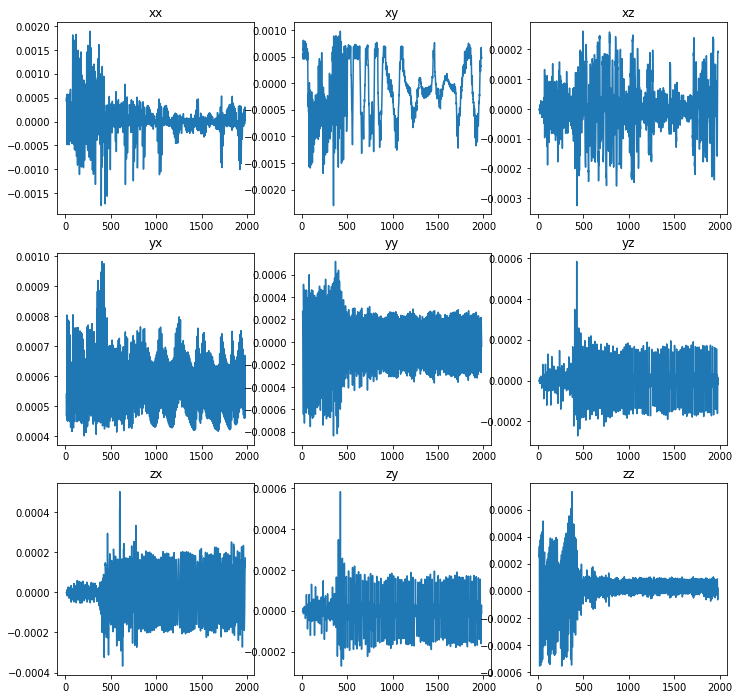

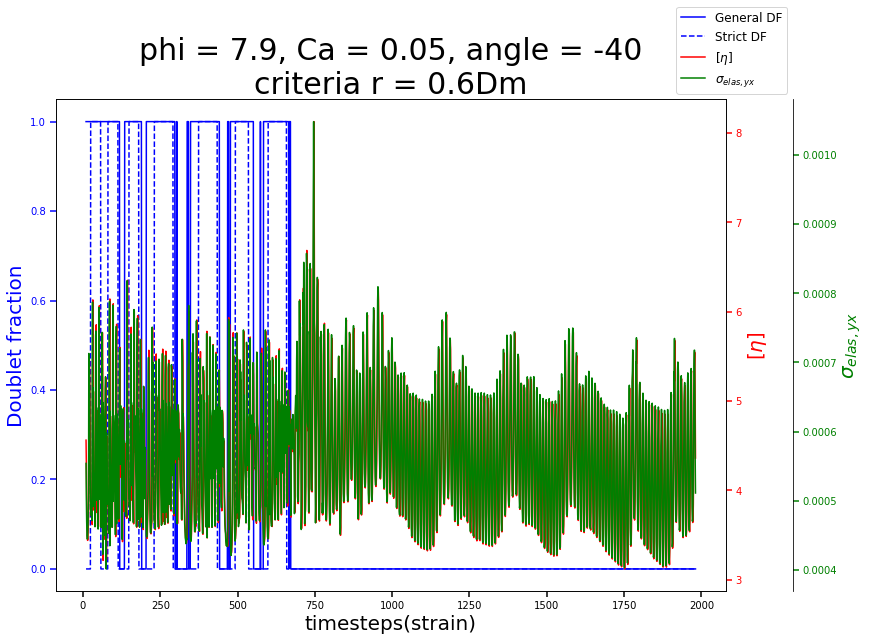

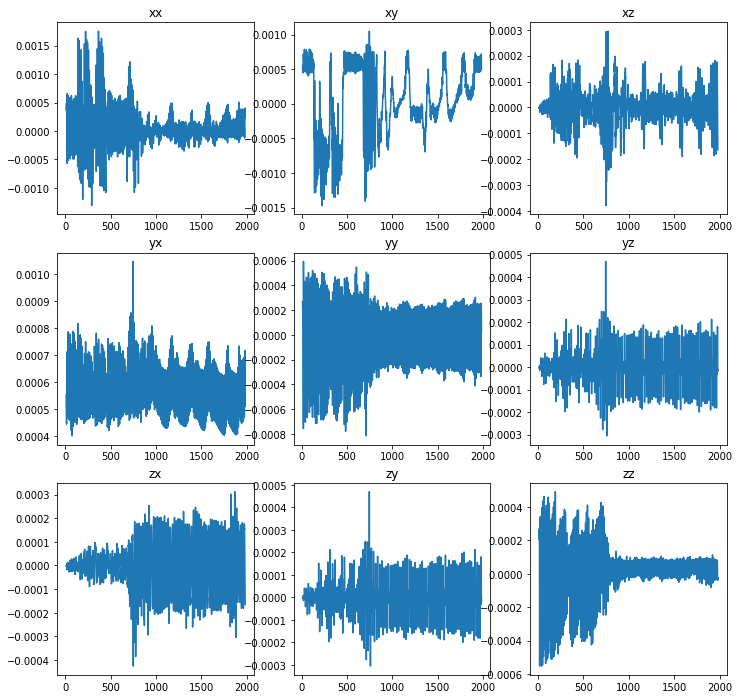

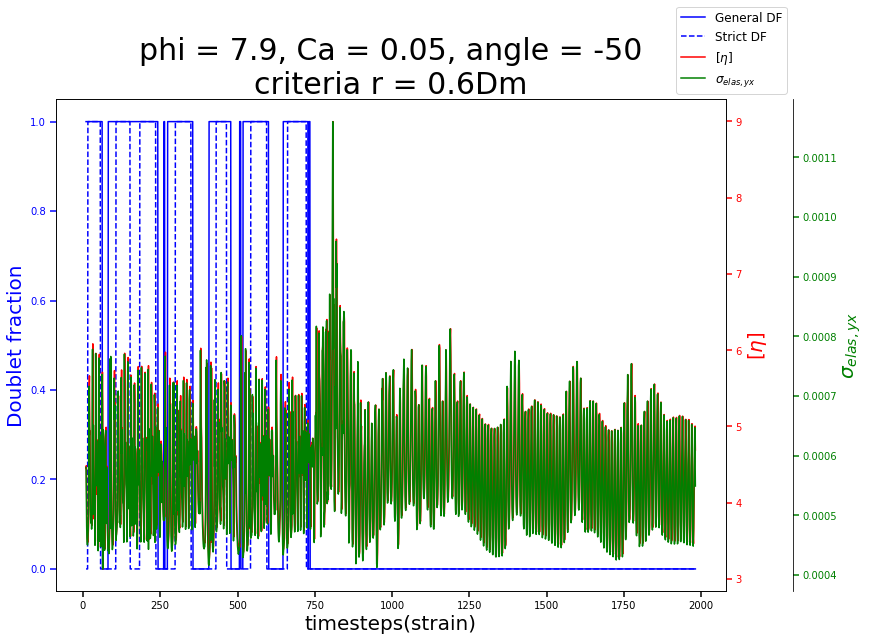

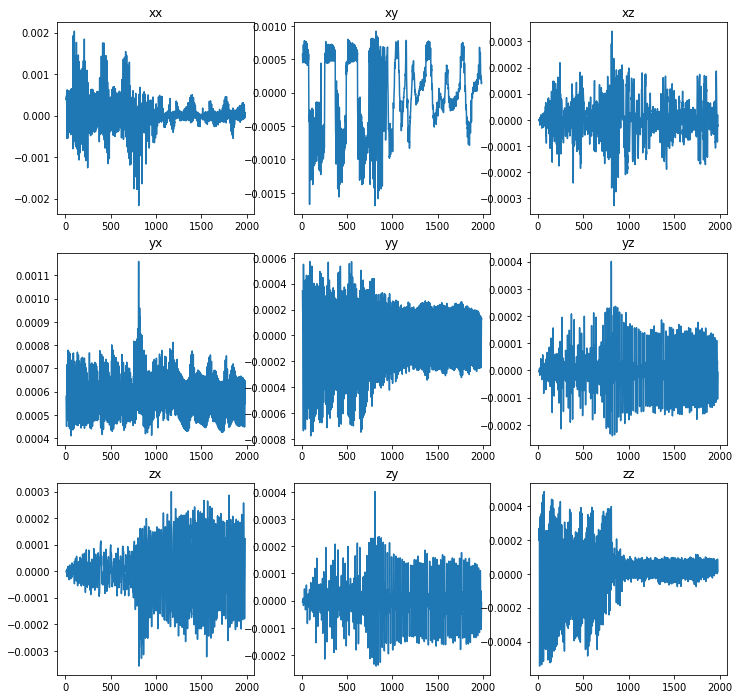

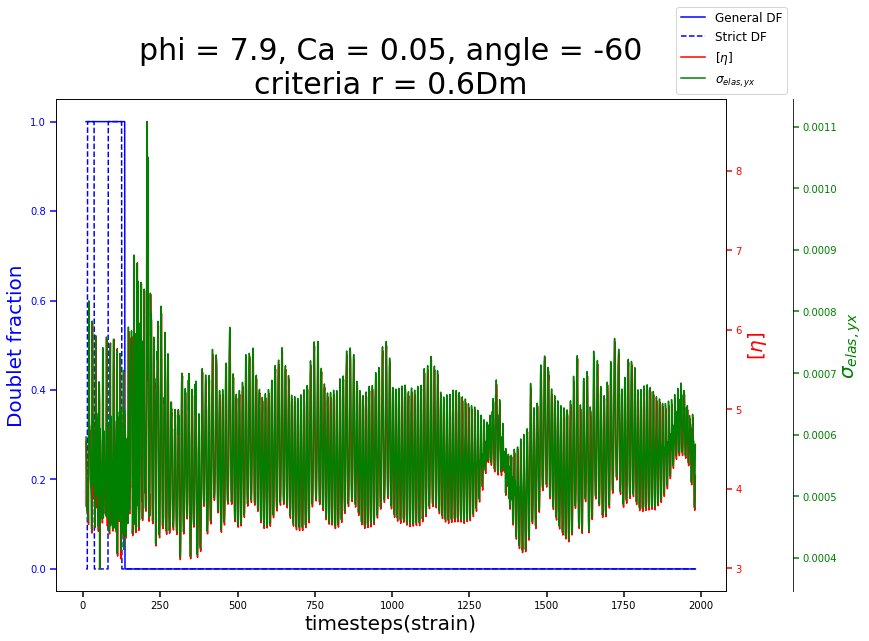

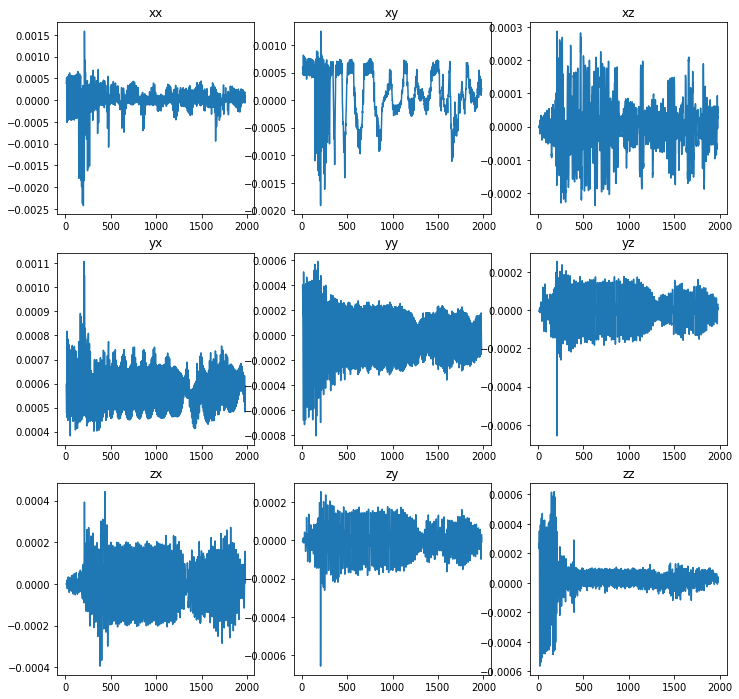

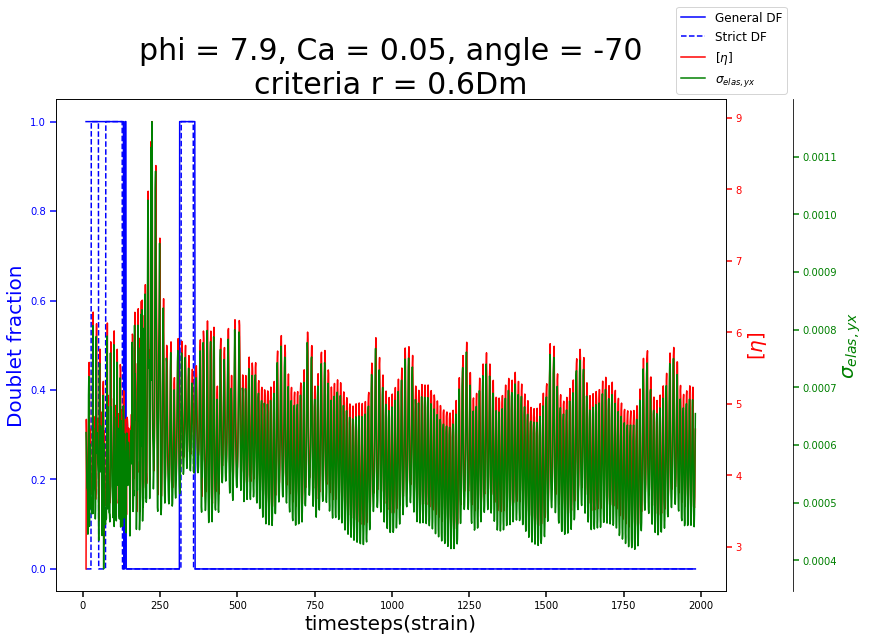

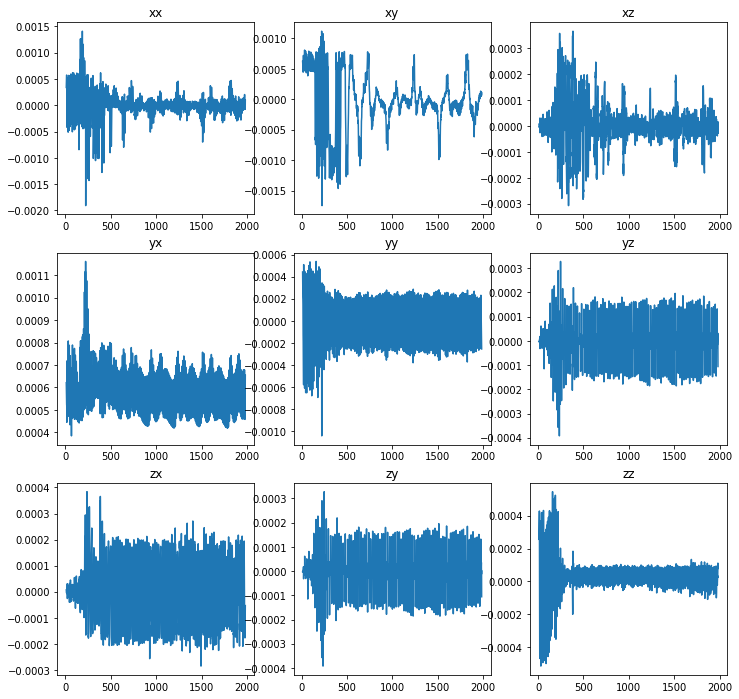

In [15]:
start_time = time.time()

r = 0.6 # criteria for inter-particle distance
ncycle = 2000
start_time_step = 10
time_window = 100
k = 0.8

# [9.9, 9.2, 7.9, 6.9, 6.0, 4.7, 3.8]
for phi in [7.9]:
    for i in range(1, 6):
        Ca = i*0.01
        for j in range(18):
            angle = 90-10*j
            result = avg_intrinsic(time_window, k)
            if result[0] != 0:
                plot_three_variables(2)              

print('Total time elapsed = {}'.format(str(datetime.timedelta(seconds=time.time()-start_time))))

9.9
Total time elapsed = 0:05:11.846895


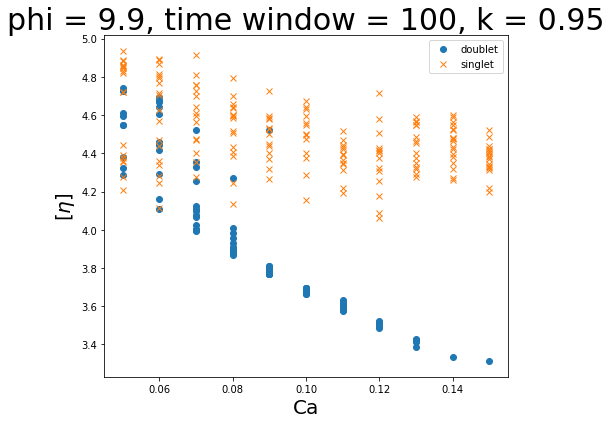

In [9]:
start_time = time.time()

r = 0.6 # criteria for inter-particle distance
ncycle = 2000
time_window = 100
k = 0.8

total_iv_avgs = [[], [], []]
total_stress_avgs = [[], [], []]
total_iv_Cas = [[], [], []]
total_stress_Cas = [[], [], []]

# [9.9, 9.2, 7.9, 6.9, 6.0, 4.7, 3.8]
for phi in [9.9]:
    print(phi)
    ## Store stat for each phi
    iv_avgs = [[], [], []]
    stress_avgs = [[], [], []]
    iv_Cas = [[], [], []]
    stress_Cas = [[], [], []]
    
    for i in range(1, 21):
        Ca = i*0.01
        ## Store stat for each Ca
        tmp_iv_avgs = [[], [], []]
        tmp_stress_avgs = [[], [], []]
        for j in range(18):
            angle = 90-10*j
            result = state_stat(time_window, k)
            for k in range(3):
                if result[0, k] != 0:
                    iv_avgs[k].append(result[1,k])
                    stress_avgs[k].append(result[2,k])
        for k in range(3):
            iv_avgs[k].extend(tmp_iv_avgs[k])
            iv_Cas[k].extend([Ca for l in range(len(tmp_iv_avgs[k]))])
            stress_avgs[k].extend(tmp_stress_avgs[k])
            stress_Cas[k].extend([Ca for l in range(len(tmp_stress_avgs[k]))])

    total_iv_avgs.append(iv_avgs)
    total_stress_avgs.append(stress_avgs)
    total_iv_Cas.append(iv_Cas)
    total_stress_Cas.append(stress_Cas)
    
    name = ["doublet", "kayaking", "sliding"]
    plt.figure(figsize = (8, 6))
    for i in range(3):
        plt.plot(iv_Cas[i], iv_avgs[i], 'o', label = name[i])
    plt.legend()
    plt.xlabel("Ca", fontsize = 20)
    plt.ylabel(r'$\left[ \eta \right]$', fontsize = 20)
    plt.title("phi = {}, time window = {}, k = {}".format(phi, time_window, k), fontsize = 30)
    plt.tight_layout()
    plt.savefig("./Pictures/test1.png", dpi=300)
    #plt.savefig('./Pictures/TwoCellSystem_IntrinsicViscosity_Ca_revised_phi_{}_r_{}_timewindow_{}_k_{}.png'.format(phi, r, time_window, k), dpi = 300)
    plt.figure(figsize = (8, 6))
    for i in range(3):
        plt.plot(stress_Cas[i], stress_avgs[i], 'o', label = name[i])
    plt.legend()
    plt.xlabel("Ca", fontsize = 20)
    plt.ylabel(r'$\left[ \eta \right]$', fontsize = 20)
    plt.title("phi = {}, time window = {}, k = {}".format(phi, time_window, k), fontsize = 30)
    plt.tight_layout()
    plt.savefig("./Pictures/test2.png", dpi=300)

print('Total time elapsed = {}'.format(str(datetime.timedelta(seconds=time.time()-start_time))))

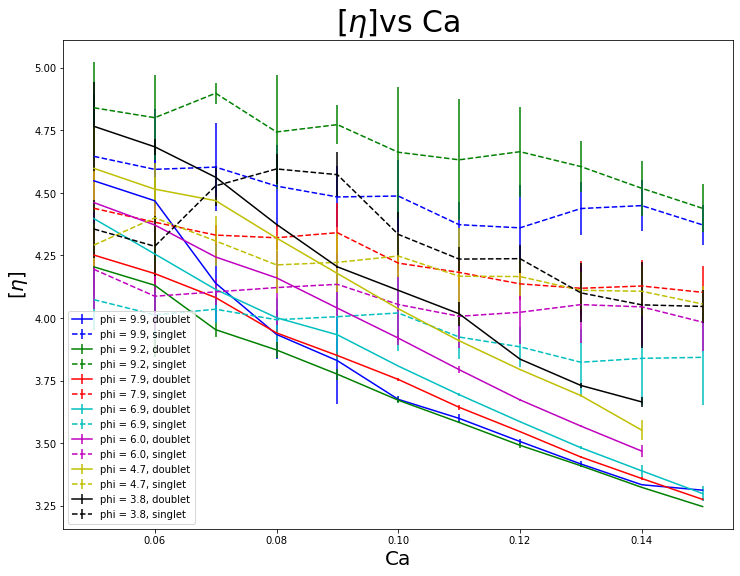

In [12]:
plt.figure(figsize=(12,9))
cmap = ['b','g','r','c','m','y','k']
for phi_index, phi in enumerate([9.9, 9.2, 7.9, 6.9, 6.0, 4.7, 3.8]):
    data1 = total_Cas_d[phi_index]
    data2 = total_doublet_avgs[phi_index]
    count = 0
    mean, std, Cas = [], [], []
    for i in range(5, 16):
        tmp_queue = []
        Ca = i*0.01
        if count >= len(data1):
            break
        while (count < len(data1)) and (data1[count] == Ca):
            tmp_queue.append(data2[count])
            count += 1
        if len(tmp_queue) != 0:
            mean.append(np.mean(tmp_queue))
            std.append(np.std(tmp_queue))
            Cas.append(Ca)
    plt.errorbar(Cas, mean, yerr = std, label = 'phi = {}, doublet'.format(phi), color = cmap[phi_index])
    
    
    data1 = total_Cas_s[phi_index]
    data2 = total_singlet_avgs[phi_index]
    count = 0
    mean, std, Cas = [], [], []
    for i in range(5, 16):
        tmp_queue = []
        Ca = i*0.01
        if count >= len(data1):
            break
        while (count < len(data1)) and (data1[count] == Ca):
            tmp_queue.append(data2[count])
            count += 1
        if len(tmp_queue) != 0:
            mean.append(np.mean(tmp_queue))
            std.append(np.std(tmp_queue))
            Cas.append(Ca)
    plt.errorbar(Cas, mean, yerr = std, label = 'phi = {}, singlet'.format(phi), ls = '--', color = cmap[phi_index])
    
plt.xlabel('Ca', fontsize = 20)
plt.ylabel(r'$\left[ \eta \right]$', fontsize = 20)
plt.title(r'$\left[ \eta \right]$'+'vs Ca', fontsize=30)
plt.legend()
#plt.savefig('./Pictures/TwoCellSystem_IntrinsicViscosity_Ca_summary_doubletonly_r_{}_timewindow_{}_k_{}.png'.format(r, time_window, k), dpi = 300)
plt.savefig('./Pictures/TwoCellSystem_IntrinsicViscosity_Ca_summary_r_{}_timewindow_{}_k_{}.png'.format(r, time_window, k), dpi = 300)

## Oscillating frequency of intrinsic viscosity in different regimes

In [ ]:
ncycle = 2000
phi, Ca, angle = 4.7, 0.17, -70
data = getInstrinsicViscosity(phi, Ca, 0, ncycle, angle)
offset = 10
P = np.fft.rfft(data)
f = np.linspace(0.0, 0.5, 1001)
plt.plot(f, np.abs(P))
period = (ncycle)/(np.argmax(np.abs(P[offset:]))+offset)
print("phi = {}, Ca = {}, angle = {}:period = {}".format(phi, Ca, angle, period))

ncycle = 2000

for i in range(20):
    phi = random.choice([3.8, 4.7, 6.0, 6.9, 7.9, 9.2, 9.9])
    Ca = random.choice([(i+1)*0.01 for i in range(20)])
    angle = random.choice([90-10*i for i in range(18)])
    data = getInstrinsicViscosity(phi, Ca, 0, ncycle, angle)
    offset = 20
    P = np.fft.rfft(data)
    f = np.linspace(0.0, 0.5, 1001)
    period = (ncycle)/(np.argmax(np.abs(P[offset:]))+offset)
    print("phi = {}, Ca = {}, angle = {}:period = {}".format(phi, Ca, angle, period))

## Three variables vs time plot
Intrinsic viscosity and elastic stress are both higher in doublet region

In [5]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def plot_three_variables(plot_or_not):
    fig, host = plt.subplots(figsize = (12, 9))
    fig.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()
    par2.spines["right"].set_position(("axes", 1.1))
    make_patch_spines_invisible(par2)
    par2.spines["right"].set_visible(True)

    r = 0.6
    result = calcDoubletFraction(phi, Ca, 1.0, r, 0, angle)
    if (len(result[0][0])>2000):
        dfs = result[0][0][:ncycle]
        dfg = result[1][0][:ncycle]
    else:  
        dfs = result[0][0]
        dfg = result[1][0]
    simul_time = list(range(len(dfs)))
    p1_1, = host.plot(simul_time[start_time_step:], dfg[start_time_step:], "b-", label = "General DF")
    p1_2, = host.plot(simul_time[start_time_step:], dfs[start_time_step:], "b-", label = "Strict DF", linestyle = '--')
    p2, = par1.plot(simul_time[start_time_step:], getInstrinsicViscosity(phi, Ca, 0, ncycle, angle)[start_time_step:len(dfs)], "r-", label = r'$\left[ \eta \right]$')
    p3, = par2.plot(simul_time[start_time_step:], getStress(phi, Ca, 0, 0, ncycle, angle)[:,3][start_time_step:len(dfs)], "g-", label = r'$\sigma _{elas, yx}$')

    host.set_title('phi = {}, Ca = {}, angle = {}\ncriteria r = {}Dm'.format(phi, Ca, angle, r), fontsize = 30)
    host.set_xlabel("timesteps(strain)", fontsize = 20)
    host.set_ylabel("Doublet fraction", fontsize = 20)
    par1.set_ylabel(r'$\left[ \eta \right]$', fontsize = 20)
    par2.set_ylabel(r'$\sigma _{elas, yx}$', fontsize = 20)

    host.yaxis.label.set_color(p1_1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=6, width=1.5)
    host.tick_params(axis='y', colors=p1_1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    lines = [p1_1, p1_2, p2, p3]
    host.legend(lines, [l.get_label() for l in lines], prop={'size': 12}, bbox_to_anchor=(1.1,1.2))
    fig.tight_layout()
    if plot_or_not == 0:
        plt.close()
    elif plot_or_not == 1:
        plt.savefig('./Pictures/TwoCellSystem_ThreeVariables_timeseries_phi_{}_Ca_{}_angle_{}_r_{}.png'.format(phi, Ca, angle, r), dpi = 300)
    return np.mean(dfg)

In [10]:
ncycle = 2000
start_time_step = 10
phi = 9.9

parameters = []
for Ca in [(i+1)*0.01 for i in range(20)]:
    for angle in [90-10*j for j in range(18)]:
        result = plot_three_variables(0)
        if ((result > 0.1) and (result < 0.7)):
            parameters.append([phi, Ca, angle])
print(parameters)

[[9.9, 0.02, 10], [9.9, 0.02, -80], [9.9, 0.03, 40], [9.9, 0.03, 30], [9.9, 0.03, 10], [9.9, 0.03, 0], [9.9, 0.03, -30], [9.9, 0.04, 0], [9.9, 0.04, -50], [9.9, 0.05, 90], [9.9, 0.05, 70], [9.9, 0.05, 60], [9.9, 0.05, 30], [9.9, 0.05, 10], [9.9, 0.05, -10], [9.9, 0.05, -20], [9.9, 0.05, -30], [9.9, 0.05, -40], [9.9, 0.05, -80], [9.9, 0.06, 60], [9.9, 0.06, 50], [9.9, 0.06, 40], [9.9, 0.06, 20], [9.9, 0.06, 10], [9.9, 0.06, -10], [9.9, 0.06, -20], [9.9, 0.06, -50], [9.9, 0.06, -60], [9.9, 0.06, -80], [9.9, 0.07, 90], [9.9, 0.07, 80], [9.9, 0.07, 70], [9.9, 0.07, 50], [9.9, 0.07, 40], [9.9, 0.07, 0], [9.9, 0.07, -20], [9.9, 0.07, -30], [9.9, 0.07, -50], [9.9, 0.08, 50], [9.9, 0.08, 40], [9.9, 0.08, 20], [9.9, 0.08, 0], [9.9, 0.08, -30], [9.9, 0.08, -40], [9.9, 0.08, -50], [9.9, 0.08, -60], [9.9, 0.09, 80], [9.9, 0.09, 70], [9.9, 0.09, 50], [9.9, 0.09, 10], [9.9, 0.09, -10], [9.9, 0.09, -20], [9.9, 0.09, -30], [9.9, 0.09, -40], [9.9, 0.09, -50], [9.9, 0.1, 80], [9.9, 0.1, 70], [9.9, 0.1, 

0.10489157841654059

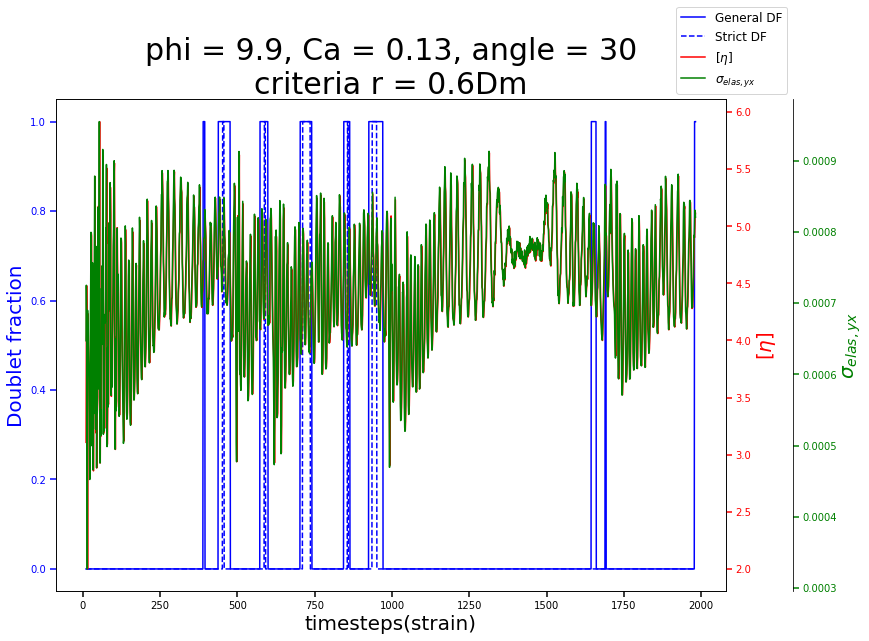

In [69]:
ncycle = 2000
start_time_step = 10
phi, Ca, angle = 9.9, 0.13, 30
plot_three_variables(2)

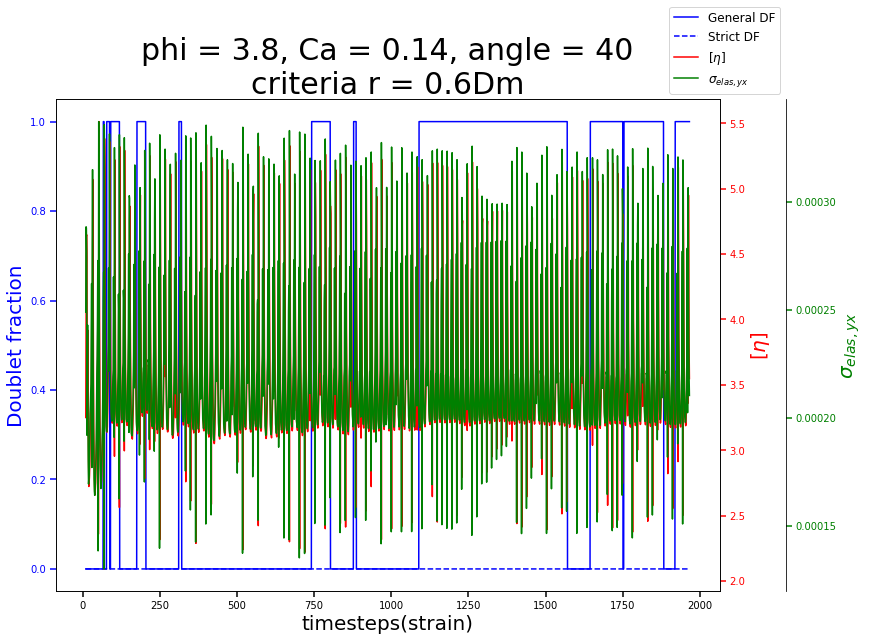

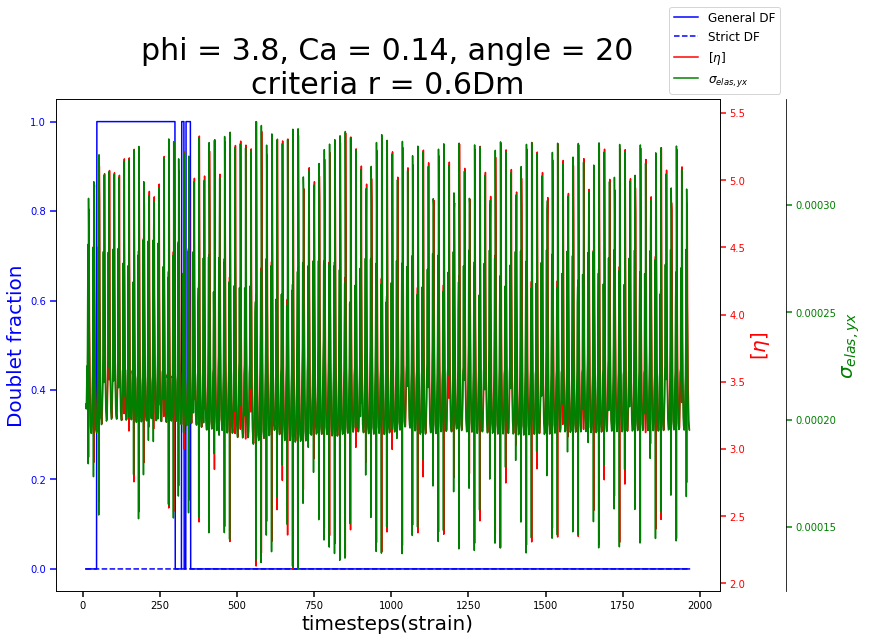

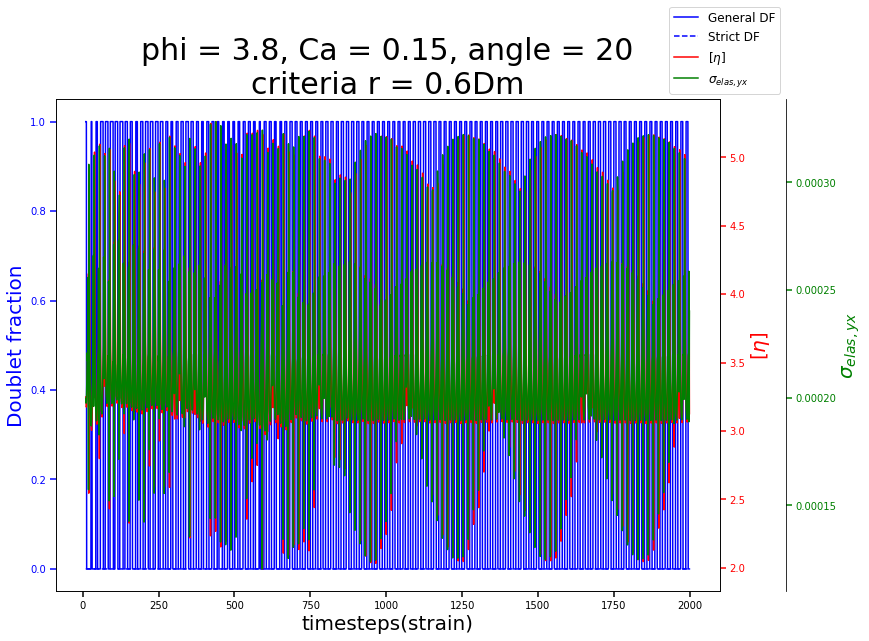

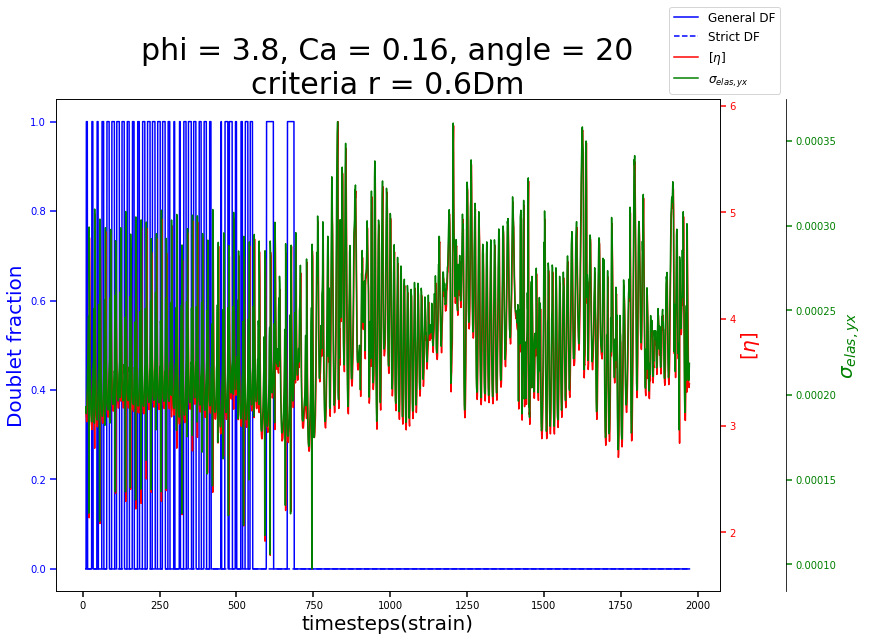

In [5]:
input_parameters = [[3.8, 0.14, 40], [3.8, 0.14, 20], [3.8, 0.15, 20], [3.8, 0.16, 20]]
ncycle = 2000
start_time_step = 10
for parameters in input_parameters:
    [phi, Ca, angle] = parameters
    plot_three_variables(2)

## intrinsic viscosity vs doublet fraction

phi = 6.9, Ca = 0.07
Total time elapsed = 0:00:04.614479


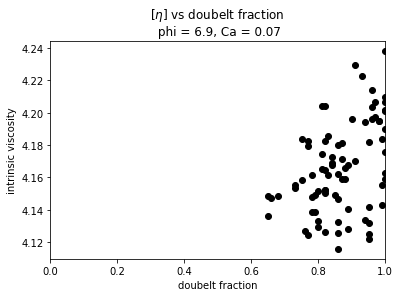

In [30]:
start_time = time.time()

ncycle = 2000
start_time_step = 250
time_slice = 100
points_per_point = int((ncycle-start_time_step)/time_slice - 1)

phi = random.choice([3.8, 4.7, 6.0, 6.9, 7.9, 9.2, 9.9])
Cas = [random.choice([(i+1)*0.01 for i in range(20)])]
phi, Cas = 6.9, [0.07]
angles = [90 - 10*i for i in range(18)]
#Cas = [(i+1)*0.01 for i in range(20)]
'''
df = np.zeros(len(Cas)*len(angles)*points_per_point)
iv = np.zeros(len(Cas)*len(angles)*points_per_point)
'''
df, iv = [], []

for Ca_index, Ca in enumerate(Cas):
    print('phi = {}, Ca = {}'.format(phi, Ca))
    for angle_index, angle in enumerate(angles):
        df_result = calcDoubletFraction(phi, Ca, 1.0, 0.6, 0, angle)[1][0][start_time_step:]
        iv_result = getInstrinsicViscosity(phi, Ca, 0, ncycle, angle)[start_time_step:(start_time_step + len(df_result))]
        for t in range(points_per_point):
            if np.mean(df_result[t*time_slice:(t+1)*time_slice]) > 0:
                df.append(np.mean(df_result[t*time_slice:(t+1)*time_slice]))
                iv.append(np.mean(iv_result[t*time_slice:(t+1)*time_slice]))
            '''
            df[(Ca_index*len(angles)+angle_index)*points_per_point + t] = np.mean(df_result[t*time_slice:(t+1)*time_slice])
            iv[(Ca_index*len(angles)+angle_index)*points_per_point + t] = np.mean(iv_result[t*time_slice:(t+1)*time_slice])
            '''
if len(df) > 0:
    plt.plot(df, iv, 'o', color = 'black')
    plt.xlabel('doubelt fraction')
    plt.xlim(0.0, 1.0)
    plt.ylabel('intrinsic viscosity')
    plt.title(r'$\left[ \eta \right]$'+' vs doubelt fraction \n phi = {}, Ca = {}'.format(phi, Ca))
else:
    print("No doublet formation!")
print('Total time elapsed = {}'.format(str(datetime.timedelta(seconds=time.time()-start_time))))